In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

In [3]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [4]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [5]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [6]:
def generate_training_dataframes():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [7]:
def generate_testing_dataframes():
    basedir = "../1/Test/ProstateX-TestLesionInformation/ProstateX-TestLesionInformation"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Test.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Test.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Test.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [8]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [9]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [10]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [11]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../1/Train/ProstateXKtrains-train-fixed"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [12]:
def fill_ktrans_images_dataframe_at_testing(dataFrame, window):
    for row in range(len(dataFrame)):
        path = "../1/Test/ProstateXKtrans-test-fixedv2/ProstateXKtrans-test-fixedv2"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state, window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [13]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()

In [14]:
testing_MRI_imgs_dataframe, testing_ktrans_imgs_dataframe = generate_testing_dataframes()

In [15]:
fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window = 40)

The ijk requested is [56 75 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #0 para el paciente ProstateX-0000 
The ijk requested is [51 61 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #1 para el paciente ProstateX-0001 
The ijk requested is [52 73 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #2 para el paciente ProstateX-0002 
The ijk requested is [68 72 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #3 para el paciente ProstateX-0002 
The ijk requested is [80 69 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #4 para el paciente ProstateX-0003 
The ijk requested is [51 54 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #5 para el paciente ProstateX-0003 
The ijk requested is [74 56 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen

Se ha cargado la k-trans imagen3d #66 para el paciente ProstateX-0038 
The ijk requested is [76 71 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #67 para el paciente ProstateX-0038 
The ijk requested is [54 74 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #68 para el paciente ProstateX-0038 
The ijk requested is [46 75 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #69 para el paciente ProstateX-0039 
The ijk requested is [50 63 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #70 para el paciente ProstateX-0040 
The ijk requested is [68 76 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #71 para el paciente ProstateX-0040 
The ijk requested is [74 68 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #72 para el paciente ProstateX-0040 
The ijk requested is [50 79 5],OK

Se ha cargado la k-trans imagen3d #131 para el paciente ProstateX-0085 
The ijk requested is [68 45 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #132 para el paciente ProstateX-0086 
The ijk requested is [51 59 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #133 para el paciente ProstateX-0086 
The ijk requested is [53 72 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #134 para el paciente ProstateX-0087 
The ijk requested is [74 59 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #135 para el paciente ProstateX-0087 
The ijk requested is [54 49 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #136 para el paciente ProstateX-0088 
The ijk requested is [55 75 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #137 para el paciente ProstateX-0088 
The ijk requested is [76 5

Se ha cargado la k-trans imagen3d #196 para el paciente ProstateX-0126 
The ijk requested is [64 58 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #197 para el paciente ProstateX-0126 
The ijk requested is [51 71 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #198 para el paciente ProstateX-0127 
The ijk requested is [53 73 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #199 para el paciente ProstateX-0128 
The ijk requested is [56 67 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #200 para el paciente ProstateX-0128 
The ijk requested is [68 68 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #201 para el paciente ProstateX-0128 
The ijk requested is [78 72 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #202 para el paciente ProstateX-0129 
The ijk requested is [41 77 

Se ha cargado la k-trans imagen3d #259 para el paciente ProstateX-0158 
The ijk requested is [69 76 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #260 para el paciente ProstateX-0159 
The ijk requested is [63 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #261 para el paciente ProstateX-0159 
The ijk requested is [69 76 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #262 para el paciente ProstateX-0159 
The ijk requested is [63 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #263 para el paciente ProstateX-0159 
The ijk requested is [48 64 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #264 para el paciente ProstateX-0159 
The ijk requested is [56 76 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #265 para el paciente ProstateX-0160 
The ijk requested is [67 78

Se ha cargado la k-trans imagen3d #321 para el paciente ProstateX-0192 
The ijk requested is [56 73 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #322 para el paciente ProstateX-0192 
The ijk requested is [62 49 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #323 para el paciente ProstateX-0193 
The ijk requested is [70 70 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #324 para el paciente ProstateX-0193 
The ijk requested is [55 67 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #325 para el paciente ProstateX-0193 
The ijk requested is [62 71 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #326 para el paciente ProstateX-0193 
The ijk requested is [49 59 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #327 para el paciente ProstateX-0194 
The ijk requested is [57 7

In [16]:
fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = 40)

The ijk requested is [53 72 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #0 para el paciente ProstateX-0204 
The ijk requested is [73 78 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #1 para el paciente ProstateX-0204 
The ijk requested is [61 73 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #2 para el paciente ProstateX-0204 
The ijk requested is [68 73 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #3 para el paciente ProstateX-0205 
The ijk requested is [79 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #4 para el paciente ProstateX-0206 
The ijk requested is [68 70 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #5 para el paciente ProstateX-0207 
The ijk requested is [71 63 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans image

Se ha cargado la k-trans imagen3d #61 para el paciente ProstateX-0247 
The ijk requested is [62 78 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #62 para el paciente ProstateX-0248 
The ijk requested is [54 77 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #63 para el paciente ProstateX-0249 
The ijk requested is [77 56 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #64 para el paciente ProstateX-0250 
The ijk requested is [51 75 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #65 para el paciente ProstateX-0250 
The ijk requested is [74 77 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #66 para el paciente ProstateX-0251 
The ijk requested is [59 81 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #67 para el paciente ProstateX-0251 
The ijk requested is [58 61 7],OK

Se ha cargado la k-trans imagen3d #124 para el paciente ProstateX-0285 
The ijk requested is [69 62 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #125 para el paciente ProstateX-0286 
The ijk requested is [54 78 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #126 para el paciente ProstateX-0286 
The ijk requested is [74 78 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #127 para el paciente ProstateX-0287 
The ijk requested is [58 67 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #128 para el paciente ProstateX-0287 
The ijk requested is [46 81 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #129 para el paciente ProstateX-0288 
The ijk requested is [59 61 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #130 para el paciente ProstateX-0288 
The ijk requested is [71 81 

The ijk requested is [62 54 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #188 para el paciente ProstateX-0334 
The ijk requested is [52 65 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #189 para el paciente ProstateX-0335 
The ijk requested is [49 59 -2],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #190 para el paciente ProstateX-0335 
The ijk requested is [60 73 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #191 para el paciente ProstateX-0336 
The ijk requested is [53 73 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #192 para el paciente ProstateX-0336 
The ijk requested is [80 69 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #193 para el paciente ProstateX-0337 
The ijk requested is [77 78 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-

In [17]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [18]:
def fill_MRI_images_dataframe_at_testing(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        path = "../1/Test/PROSTATEx/{}".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [31]:
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = 40)

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-48780
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [36 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #0 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-69284
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [36 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-69284
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [36 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence select

The ijk requested is [33 71 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #22 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [33 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #23 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [33 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #24 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [33 71 12],OK since shapes 

The ijk requested is [54 68 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #44 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [54 68 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #45 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [54 68 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #46 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [54 68 11],OK since shapes 

The ijk requested is [50 58 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #68 para el paciente ProstateX-0004 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-63070
The requested sequence is t2_tse_cor0
The ijk requested is [173 172 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #69 para el paciente ProstateX-0004 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-00386
The requested sequence is t2_tse_sag0
The ijk requested is [132 174 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #70 para el paciente ProstateX-0004 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-75680
The requested sequence is t2_tse_tra0
The ijk requested is [221 168 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATC

The ijk requested is [42 63 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #90 para el paciente ProstateX-0005 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-18975
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [34 71 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #91 para el paciente ProstateX-0005 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-05098
The requested sequence is t2_tse_cor0
The ijk requested is [156 151 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #92 para el paciente ProstateX-0005 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-05098
The requested sequence is t2_tse_cor0
The ijk requested is [128 151 10],OK since shapes of th

Se ha cargado la imagen MRI3D y MRI3DPATCH #112 para el paciente ProstateX-0005 serie: t2_tse_sag 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-65685
The requested sequence is t2_tse_sag0
The ijk requested is [184 153 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #113 para el paciente ProstateX-0005 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-91330
The requested sequence is t2_tse_tra0
The ijk requested is [190 185 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #114 para el paciente ProstateX-0005 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-91330
The requested sequence is t2_tse_tra0
The ijk requested is [157 219 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #115 para el paciente ProstateX-0005 serie: t2_tse_tra 
The condition is true 9 = 9
The seque

Se ha cargado la imagen MRI3D y MRI3DPATCH #135 para el paciente ProstateX-0006 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-47733
The requested sequence is t2_tse_cor0
The ijk requested is [152 138 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #136 para el paciente ProstateX-0006 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-19869
The requested sequence is t2_tse_sag0
The ijk requested is [179 141 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #137 para el paciente ProstateX-0006 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-98209
The requested sequence is t2_tse_tra0
The ijk requested is [186 221 15],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #138 para el paciente ProstateX-0006 serie: t2_tse_tra 
The condition is true 9 = 9
The seq

The ijk requested is [153 146 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #158 para el paciente ProstateX-0008 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-30647
The requested sequence is t2_tse_cor0
The ijk requested is [185 156 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #159 para el paciente ProstateX-0008 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-46088
The requested sequence is t2_tse_sag0
The ijk requested is [166 155 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #160 para el paciente ProstateX-0008 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-69918
The requested sequence is t2_tse_sag0
The ijk requested is [166 155 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #161 para el 

The ijk requested is [161 164 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #181 para el paciente ProstateX-0010 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-36511
The requested sequence is t2_tse_cor0
The ijk requested is [122 165 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #182 para el paciente ProstateX-0010 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-77639
The requested sequence is t2_tse_sag0
The ijk requested is [166 169 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #183 para el paciente ProstateX-0010 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-07664
The requested sequence is t2_tse_tra0
The ijk requested is [150 213 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #184 para e

The ijk requested is [160 131 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #203 para el paciente ProstateX-0012 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-69243
The requested sequence is t2_tse_cor0
The ijk requested is [154 161 14], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #204 para el paciente ProstateX-0012 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-75948
The requested sequence is t2_tse_sag0
The ijk requested is [201 167 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #205 para el paciente ProstateX-0012 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-91229
The requested sequence is t2_tse_sag0
The ijk requested is [201 167 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y M

The ijk requested is [25 67 11],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #225 para el paciente ProstateX-0013 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-16098
The requested sequence is t2_loc_sag0
The ijk requested is [137 126 5], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #226 para el paciente ProstateX-0013 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-25232
The requested sequence is t2_localizer0
The ijk requested is [148 125 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #227 para el paciente ProstateX-0013 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-52651
The requested sequence is t2_tse_cor0
The ijk requested is [105 146 11],OK since shapes of the image is (19, 320, 320)
Se ha ca

The ijk requested is [131 176 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #247 para el paciente ProstateX-0015 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-75041
The requested sequence is t2_tse_tra0
The ijk requested is [216 154 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #248 para el paciente ProstateX-0015 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-75352
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [72 52 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #249 para el paciente ProstateX-0015 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-29603
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [37 59 5],OK since shapes of the image i

The ijk requested is [192 186 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #269 para el paciente ProstateX-0017 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-39653
The requested sequence is t2_tse_tra0
The ijk requested is [202 233 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #270 para el paciente ProstateX-0017 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17803
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [68 78 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #271 para el paciente ProstateX-0017 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-31899
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [45 60 6],OK since shapes of the image i

The ijk requested is [198 166 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #291 para el paciente ProstateX-0019 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-65888
The requested sequence is t2_tse_tra0
The ijk requested is [182 236 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #292 para el paciente ProstateX-0019 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-13923
The requested sequence is t2_tse_tra0
The ijk requested is [182 236 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #293 para el paciente ProstateX-0019 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-37958
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [61 79 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imag

The ijk requested is [56 61 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #314 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73387
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [56 61 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #315 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73387
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [56 61 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #316 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73387
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [56 61 8],OK since shapes o

The ijk requested is [29 66 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #338 para el paciente ProstateX-0023 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-01030
The requested sequence is t2_loc_sag0
The ijk requested is [137 131 4], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #339 para el paciente ProstateX-0023 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-16733
The requested sequence is t2_localizer0
The ijk requested is [149 120 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #340 para el paciente ProstateX-0023 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-43754
The requested sequence is t2_tse_cor0
The ijk requested is [111 152 10],OK since shapes of the image is (15, 320, 320)
Se ha cargad

The ijk requested is [44 57 8],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #360 para el paciente ProstateX-0024 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-69282
The requested sequence is t2_loc_sag0
The ijk requested is [126 135 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #361 para el paciente ProstateX-0024 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-44527
The requested sequence is t2_localizer0
The ijk requested is [145 145 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #362 para el paciente ProstateX-0024 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-49120
The requested sequence is t2_tse_cor0
The ijk requested is [160 203 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [55 74 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #383 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17931
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [61 66 25], there was an error since the shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #384 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17931
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [45 82 -8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #385 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17931
The reque

The ijk requested is [55 74 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #407 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [61 66 25],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #408 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [45 82 -8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #409 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [51 75 9],OK since shapes of 

The ijk requested is [243 231 9],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #431 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10038
The requested sequence is t2_tse_tra0
The ijk requested is [266 200 26], there was an error since the shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #432 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10038
The requested sequence is t2_tse_tra0
The ijk requested is [201 262 -8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #433 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10038
The requested sequence is t2_tse_tra0
The ijk requested is [225 236 9],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [212 236 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #453 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10038
The requested sequence is t2_tse_tra0
The ijk requested is [169 267 -8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #454 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17142
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [71 79 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #455 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17142
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [57 89 -7],OK since shapes of th

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [54 62 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #477 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [44 69 -13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #478 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [54 62 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #479 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected 

The ijk requested is [161 205 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #499 para el paciente ProstateX-0026 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-21032
The requested sequence is t2_tse_tra0
The ijk requested is [175 197 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #500 para el paciente ProstateX-0026 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-30224
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [59 66 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #501 para el paciente ProstateX-0026 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-33284
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 77 10],OK since shapes of the image

Se ha cargado la imagen MRI3D y MRI3DPATCH #523 para el paciente ProstateX-0028 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-83453
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [32 69 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #524 para el paciente ProstateX-0028 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-42366
The requested sequence is t2_tse_cor0
The ijk requested is [129 163 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #525 para el paciente ProstateX-0028 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54011
The requested sequence is t2_tse_sag0
The ijk requested is [178 166 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #526 para el paciente Prosta

The ijk requested is [222 200 12],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #545 para el paciente ProstateX-0030 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-88807
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 67 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #546 para el paciente ProstateX-0030 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-69372
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [52 69 17],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #547 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 11 = 11
The sequence selected is 11-ep2ddifftraDYNDISTADC-65134
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk request

Se ha cargado la imagen MRI3D y MRI3DPATCH #567 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 10 = 10
The sequence selected is 10-ep2ddifftraDYNDIST-84006
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 70 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #568 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-06107
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 69 17],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #569 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-06107
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 69 17],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #57

The ijk requested is [230 240 15],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #589 para el paciente ProstateX-0032 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-78436
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [77 81 14],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #590 para el paciente ProstateX-0032 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-30280
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 72 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #591 para el paciente ProstateX-0033 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-87720
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 7

The ijk requested is [45 76 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #613 para el paciente ProstateX-0034 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 11 = 11
The sequence selected is 11-t2localizer-83362
The requested sequence is t2_localizer0
The ijk requested is [153 121 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #614 para el paciente ProstateX-0034 serie: t2_localizer 
The condition is true 3 = 3
The sequence selected is 3-t2tsecor-84687
The requested sequence is t2_tse_cor0
The ijk requested is [168 129 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #615 para el paciente ProstateX-0034 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-23773
The requested sequence is t2_tse_sag0
The ijk requested is [213 130 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D 

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-98647
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [52 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #641 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73447
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [52 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #642 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73447
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [52 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #643 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence 

The ijk requested is [34 63 10],OK since shapes of the image is (18, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #668 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 63 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #669 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 63 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #670 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 63 10],OK since shap

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #691 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #692 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #693 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is

The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #713 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-20696
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #714 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-20696
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #715 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-93935
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [32 63 12],

The ijk requested is [175 181 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #736 para el paciente ProstateX-0040 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-14576
The requested sequence is t2_tse_tra0
The ijk requested is [222 204 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #737 para el paciente ProstateX-0040 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-63465
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 68 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #738 para el paciente ProstateX-0040 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-98235
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [32 75 5],OK since shapes of the imag

The ijk requested is [35 73 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #758 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98519
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 73 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #759 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 73 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #760 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98519
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 73 15],OK since shap

The ijk requested is [48 56 12],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #780 para el paciente ProstateX-0045 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-37987
The requested sequence is t2_loc_sag0
The ijk requested is [130 125 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #781 para el paciente ProstateX-0045 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-10765
The requested sequence is t2_localizer0
The ijk requested is [137 117 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #782 para el paciente ProstateX-0045 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31918
The requested sequence is t2_tse_cor0
The ijk requested is [185 135 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [43 69 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #802 para el paciente ProstateX-0046 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-72046
The requested sequence is t2_loc_sag0
The ijk requested is [133 137 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #803 para el paciente ProstateX-0046 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-88182
The requested sequence is t2_localizer0
The ijk requested is [130 106 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #804 para el paciente ProstateX-0046 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-59688
The requested sequence is t2_tse_cor0
The ijk requested is [155 169 12],OK since shapes of the image is (15, 320, 320)
Se ha car

The ijk requested is [52 68 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #824 para el paciente ProstateX-0048 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-57233
The requested sequence is t2_loc_sag0
The ijk requested is [136 141 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #825 para el paciente ProstateX-0048 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-22808
The requested sequence is t2_localizer0
The ijk requested is [159 182 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #826 para el paciente ProstateX-0048 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-49567
The requested sequence is t2_tse_cor0
The ijk requested is [188 177 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [139 145 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #846 para el paciente ProstateX-0050 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-15690
The requested sequence is t2_tse_cor0
The ijk requested is [182 190 11],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #847 para el paciente ProstateX-0050 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54503
The requested sequence is t2_tse_sag0
The ijk requested is [136 185 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #848 para el paciente ProstateX-0050 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-81973
The requested sequence is t2_tse_tra0
The ijk requested is [218 190 7],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #849 para el 

The ijk requested is [213 143 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #868 para el paciente ProstateX-0052 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-75167
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [71 48 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #869 para el paciente ProstateX-0052 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-90274
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [52 67 12],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #870 para el paciente ProstateX-0053 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-89704
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [5

The ijk requested is [54 70 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #892 para el paciente ProstateX-0054 serie: ep2d_diff_tra_DYNDIST 
The condition is true 12 = 12
The sequence selected is 12-ep2ddifftraDYNDISTCALCBVAL-64930
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [54 70 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #893 para el paciente ProstateX-0054 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 9 = 9
The sequence selected is 9-t2tsecor-42377
The requested sequence is t2_tse_cor0
The ijk requested is [196 173 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #894 para el paciente ProstateX-0054 serie: t2_tse_cor 
The condition is true 7 = 7
The sequence selected is 7-t2tsesag-35451
The requested sequence is t2_tse_sag0
The ijk requested is [168 172 6],OK since shapes of the image is (21, 32

The ijk requested is [137 208 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #914 para el paciente ProstateX-0056 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-25861
The requested sequence is t2_tse_tra0
The ijk requested is [165 168 7],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #915 para el paciente ProstateX-0056 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-40092
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [55 56 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #916 para el paciente ProstateX-0056 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-49955
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 72 14],OK since shapes of the im

The ijk requested is [34 59 11],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #937 para el paciente ProstateX-0058 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85366
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 59 11],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #938 para el paciente ProstateX-0058 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85366
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 59 11],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #939 para el paciente ProstateX-0058 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85366
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 59 11],OK since shap

The ijk requested is [49 55 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #960 para el paciente ProstateX-0060 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-39811
The requested sequence is t2_tse_cor0
The ijk requested is [184 178 8],OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #961 para el paciente ProstateX-0060 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-29013
The requested sequence is t2_tse_sag0
The ijk requested is [123 160 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #962 para el paciente ProstateX-0060 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-55272
The requested sequence is t2_tse_tra0
The ijk requested is [220 153 5],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH

The ijk requested is [173 171 6],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #982 para el paciente ProstateX-0062 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-78276
The requested sequence is t2_tse_sag0
The ijk requested is [150 165 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #983 para el paciente ProstateX-0062 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-70942
The requested sequence is t2_tse_tra0
The ijk requested is [207 181 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #984 para el paciente ProstateX-0062 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-26931
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [69 61 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI

The ijk requested is [49 66 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1005 para el paciente ProstateX-0065 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-43146
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [49 66 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1006 para el paciente ProstateX-0065 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-43146
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [49 66 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1007 para el paciente ProstateX-0065 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-43146
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [41 65 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1027 para el paciente ProstateX-0066 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-93617
The requested sequence is t2_loc_sag0
The ijk requested is [143 126 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1028 para el paciente ProstateX-0066 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-42858
The requested sequence is t2_localizer0
The ijk requested is [143 138 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1029 para el paciente ProstateX-0066 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-36081
The requested sequence is t2_tse_cor0
The ijk requested is [159 139 11],OK since shapes of the image is (21, 320, 320)
Se ha car

The ijk requested is [50 65 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1049 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-87635
The requested sequence is t2_loc_sag0
The ijk requested is [137 153 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1050 para el paciente ProstateX-0067 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-52028
The requested sequence is t2_localizer0
The ijk requested is [152 118 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1051 para el paciente ProstateX-0067 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-09734
The requested sequence is t2_tse_cor0
The ijk requested is [169 173 10],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y

The ijk requested is [47 74 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1071 para el paciente ProstateX-0068 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-88644
The requested sequence is t2_tse_cor0
The ijk requested is [147 172 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1072 para el paciente ProstateX-0068 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-73164
The requested sequence is t2_tse_sag0
The ijk requested is [196 174 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1073 para el paciente ProstateX-0068 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-88897
The requested sequence is t2_tse_tra0
The ijk requested is [209 229 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-89538
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 65 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1094 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-39408
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 65 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1095 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-39408
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 65 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1096 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequen

The ijk requested is [38 58 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1118 para el paciente ProstateX-0070 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-26211
The requested sequence is t2_tse_cor0
The ijk requested is [140 179 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1119 para el paciente ProstateX-0070 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-01948
The requested sequence is t2_tse_sag0
The ijk requested is [151 183 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1120 para el paciente ProstateX-0070 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-41361
The requested sequence is t2_tse_tra0
The ijk requested is [175 166 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [56 60 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1140 para el paciente ProstateX-0072 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-23637
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [49 74 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1141 para el paciente ProstateX-0073 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-32022
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [49 74 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1142 para el paciente ProstateX-0073 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-32022
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 74 6]

The ijk requested is [67 75 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1162 para el paciente ProstateX-0074 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-11492
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [53 65 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1163 para el paciente ProstateX-0075 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-33133
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [53 65 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1164 para el paciente ProstateX-0075 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-33133
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [53 65

The ijk requested is [32 72 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1184 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-24670
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [32 72 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1185 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-24670
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [32 72 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1186 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-34326
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [32 72 1

The ijk requested is [49 64 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1208 para el paciente ProstateX-0079 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-02182
The requested sequence is t2_loc_sag0
The ijk requested is [132 140 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1209 para el paciente ProstateX-0079 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-51603
The requested sequence is t2_localizer0
The ijk requested is [132 159 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1210 para el paciente ProstateX-0079 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-04455
The requested sequence is t2_tse_cor0
The ijk requested is [181 208 11],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y

The condition is true 3 = 3
The sequence selected is 3-t2tsesag-67127
The requested sequence is t2_tse_sag0
The ijk requested is [216 197 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1231 para el paciente ProstateX-0081 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-00858
The requested sequence is t2_tse_tra0
The ijk requested is [206 244 10],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1232 para el paciente ProstateX-0081 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-29262
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [69 82 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1233 para el paciente ProstateX-0081 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-85505
Th

The ijk requested is [186 147 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1253 para el paciente ProstateX-0083 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-08935
The requested sequence is t2_tse_tra0
The ijk requested is [200 218 13],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1254 para el paciente ProstateX-0083 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-62680
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [67 73 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1255 para el paciente ProstateX-0083 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-70040
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [41 68 15],OK since shapes of the i

The ijk requested is [166 158 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1275 para el paciente ProstateX-0084 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-71210
The requested sequence is t2_tse_tra0
The ijk requested is [220 195 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1276 para el paciente ProstateX-0084 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-72025
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 65 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1277 para el paciente ProstateX-0084 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-98782
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [36 65 5],OK since shapes of t

The ijk requested is [163 158 17],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1297 para el paciente ProstateX-0085 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-61230
The requested sequence is t2_tse_tra0
The ijk requested is [137 218 14],OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1298 para el paciente ProstateX-0085 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-55133
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [46 73 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1299 para el paciente ProstateX-0085 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-37997
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [33 67 16],OK since shapes o

Se ha cargado la imagen MRI3D y MRI3DPATCH #1319 para el paciente ProstateX-0085 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-61230
The requested sequence is t2_tse_tra0
The ijk requested is [192 160 14],OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1320 para el paciente ProstateX-0085 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-55133
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [64 54 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1321 para el paciente ProstateX-0085 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-37997
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [44 67 7],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1322 para

Se ha cargado la imagen MRI3D y MRI3DPATCH #1341 para el paciente ProstateX-0086 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-77772
The requested sequence is t2_tse_sag0
The ijk requested is [121 145 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1342 para el paciente ProstateX-0086 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-82393
The requested sequence is t2_tse_tra0
The ijk requested is [203 133 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1343 para el paciente ProstateX-0086 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-20999
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [68 45 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1344 para el paciente ProstateX-0086 serie: tfl_3d PD re

The ijk requested is [177 219 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1363 para el paciente ProstateX-0087 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-46289
The requested sequence is t2_tse_tra0
The ijk requested is [158 215 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1364 para el paciente ProstateX-0087 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-82615
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 72 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1365 para el paciente ProstateX-0087 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-26905
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [49 60 8],OK since shapes of the ima

Se ha cargado la imagen MRI3D y MRI3DPATCH #1385 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 72 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1386 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 72 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1387 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 72 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH

The ijk requested is [45 62 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1408 para el paciente ProstateX-0090 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-18709
The requested sequence is t2_loc_sag0
The ijk requested is [132 136 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1409 para el paciente ProstateX-0090 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-18917
The requested sequence is t2_localizer0
The ijk requested is [135 140 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1410 para el paciente ProstateX-0090 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-65545
The requested sequence is t2_tse_cor0
The ijk requested is [167 174 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3

The ijk requested is [129 191 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1431 para el paciente ProstateX-0092 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-30964
The requested sequence is t2_tse_sag0
The ijk requested is [124 193 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1432 para el paciente ProstateX-0092 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-51217
The requested sequence is t2_tse_tra0
The ijk requested is [159 178 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1433 para el paciente ProstateX-0092 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-01590
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 60 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen

The ijk requested is [33 68 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1456 para el paciente ProstateX-0093 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-76787
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [33 68 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1457 para el paciente ProstateX-0093 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-24775
The requested sequence is t2_tse_cor0
The ijk requested is [117 162 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1458 para el paciente ProstateX-0093 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-37913
The requested sequence is t2_tse_sag0
The ijk requested is [143 130 15],OK since shapes of the image is (19, 

The ijk requested is [150 118 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1479 para el paciente ProstateX-0095 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-05715
The requested sequence is t2_tse_cor0
The ijk requested is [143 151 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1480 para el paciente ProstateX-0095 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-50733
The requested sequence is t2_tse_sag0
The ijk requested is [195 152 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1481 para el paciente ProstateX-0095 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-29213
The requested sequence is t2_tse_tra0
The ijk requested is [171 214 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1482 pa

The ijk requested is [35 63 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1501 para el paciente ProstateX-0096 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-79088
The requested sequence is t2_loc_sag0
The ijk requested is [138 123 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1502 para el paciente ProstateX-0096 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-52079
The requested sequence is t2_localizer0
The ijk requested is [143 114 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1503 para el paciente ProstateX-0096 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-32608
The requested sequence is t2_tse_cor0
The ijk requested is [148 169 12],OK since shapes of the image is (17, 320, 320)
Se ha carg

The ijk requested is [154 108 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1524 para el paciente ProstateX-0098 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-39458
The requested sequence is t2_tse_cor0
The ijk requested is [147 147 17], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1525 para el paciente ProstateX-0098 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-78033
The requested sequence is t2_tse_sag0
The ijk requested is [185 144 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1526 para el paciente ProstateX-0098 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-97249
The requested sequence is t2_tse_tra0
The ijk requested is [184 230 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D 

The ijk requested is [147 231 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1547 para el paciente ProstateX-0099 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-56098
The requested sequence is t2_tse_tra0
The ijk requested is [147 231 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1548 para el paciente ProstateX-0099 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-36906
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [49 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1549 para el paciente ProstateX-0099 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-96944
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 55 4],OK since shapes of the

The ijk requested is [41 68 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1569 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-42695
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [41 68 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1570 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-42695
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [41 68 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1571 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-88508
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [41 68 9],O

The ijk requested is [51 74 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1591 para el paciente ProstateX-0101 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-93606
The requested sequence is t2_tse_cor0
The ijk requested is [190 174 16],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1592 para el paciente ProstateX-0101 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-87128
The requested sequence is t2_tse_sag0
The ijk requested is [194 182 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1593 para el paciente ProstateX-0101 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-23224
The requested sequence is t2_tse_tra0
The ijk requested is [228 232 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [193 154 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1613 para el paciente ProstateX-0103 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-11450
The requested sequence is t2_tse_tra0
The ijk requested is [222 231 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1614 para el paciente ProstateX-0103 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-47666
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 77 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1615 para el paciente ProstateX-0103 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-22329
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [40 77 11],OK since shapes o

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-09060
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 75 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1635 para el paciente ProstateX-0104 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-09060
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 75 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1636 para el paciente ProstateX-0104 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-09060
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 75 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1637 para el paciente ProstateX-0104 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selec

The ijk requested is [191 145 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1659 para el paciente ProstateX-0105 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-10025
The requested sequence is t2_tse_tra0
The ijk requested is [182 226 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1660 para el paciente ProstateX-0105 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-82153
The requested sequence is t2_tse_tra0
The ijk requested is [182 226 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1661 para el paciente ProstateX-0105 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-30189
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [61 76 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la 

The ijk requested is [54 72 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1681 para el paciente ProstateX-0106 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-29406
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [41 55 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1682 para el paciente ProstateX-0106 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-87758
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [41 55 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1683 para el paciente ProstateX-0106 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-87758
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [41 55 6

The ijk requested is [30 69 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1704 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-16452
The requested sequence is t2_tse_cor0
The ijk requested is [113 173 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1705 para el paciente ProstateX-0108 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-95980
The requested sequence is t2_tse_sag0
The ijk requested is [180 159 16],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1706 para el paciente ProstateX-0108 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10739
The requested sequence is t2_tse_tra0
The ijk requested is [143 211 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [142 188 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1726 para el paciente ProstateX-0109 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-06498
The requested sequence is t2_tse_tra0
The ijk requested is [212 163 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1727 para el paciente ProstateX-0109 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-45197
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [71 55 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1728 para el paciente ProstateX-0109 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-09054
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [46 54 10],OK since shapes of the ima

The ijk requested is [68 50 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1748 para el paciente ProstateX-0110 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-29724
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [32 61 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1749 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-12399
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [32 61 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1750 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-12399
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [32 61 9]

The ijk requested is [49 70 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1771 para el paciente ProstateX-0112 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-59641
The requested sequence is t2_loc_sag0
The ijk requested is [134 138 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1772 para el paciente ProstateX-0112 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-57650
The requested sequence is t2_localizer0
The ijk requested is [147 134 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1773 para el paciente ProstateX-0112 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-37374
The requested sequence is t2_tse_cor0
The ijk requested is [183 185 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y

The ijk requested is [43 68 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1793 para el paciente ProstateX-0114 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31183
The requested sequence is t2_tse_cor0
The ijk requested is [169 162 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1794 para el paciente ProstateX-0114 serie: t2_tse_cor 
The condition is true 10 = 10
The sequence selected is 10-t2tsesag-74928
The requested sequence is t2_tse_sag0
The ijk requested is [170 159 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1795 para el paciente ProstateX-0114 serie: t2_tse_sag 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-23907
The requested sequence is t2_tse_sag0
The ijk requested is [170 159 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D 

The ijk requested is [39 63 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1815 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-07652
The requested sequence is t2_loc_sag0
The ijk requested is [142 144 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1816 para el paciente ProstateX-0115 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-58007
The requested sequence is t2_localizer0
The ijk requested is [139 140 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1817 para el paciente ProstateX-0115 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-07923
The requested sequence is t2_tse_cor0
The ijk requested is [149 151 5],OK since shapes of the image is (15, 320, 320)
Se ha 

The ijk requested is [144 151 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1838 para el paciente ProstateX-0117 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-77542
The requested sequence is t2_tse_cor0
The ijk requested is [195 136 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1839 para el paciente ProstateX-0117 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-57645
The requested sequence is t2_tse_sag0
The ijk requested is [150 133 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1840 para el paciente ProstateX-0117 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-52963
The requested sequence is t2_tse_tra0
The ijk requested is [217 176 14],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1841 para

The ijk requested is [147 130 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1860 para el paciente ProstateX-0118 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-85632
The requested sequence is t2_tse_cor0
The ijk requested is [152 163 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1861 para el paciente ProstateX-0118 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-17530
The requested sequence is t2_tse_sag0
The ijk requested is [158 167 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1862 para el paciente ProstateX-0118 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-66189
The requested sequence is t2_tse_tra0
The ijk requested is [194 185 10],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1863 para

The ijk requested is [144 142 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1882 para el paciente ProstateX-0119 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-07432
The requested sequence is t2_tse_cor0
The ijk requested is [178 193 12],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1883 para el paciente ProstateX-0119 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-31190
The requested sequence is t2_tse_sag0
The ijk requested is [164 185 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1884 para el paciente ProstateX-0119 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-31393
The requested sequence is t2_tse_tra0
The ijk requested is [219 197 7],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1885 para

The ijk requested is [158 91 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1904 para el paciente ProstateX-0120 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-71695
The requested sequence is t2_tse_cor0
The ijk requested is [177 149 19], there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1905 para el paciente ProstateX-0120 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-91305
The requested sequence is t2_tse_sag0
The ijk requested is [195 158 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1906 para el paciente ProstateX-0120 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-02055
The requested sequence is t2_tse_tra0
The ijk requested is [210 251 14],OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [40 52 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1927 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [40 52 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1928 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [40 52 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1929 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [46 73 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1951 para el paciente ProstateX-0123 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-31625
The requested sequence is t2_loc_sag0
The ijk requested is [141 144 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1952 para el paciente ProstateX-0123 serie: t2_loc sag 
The condition is true 3 = 3
The sequence selected is 3-t2loc tra-42032
The requested sequence is t2_loc_tra0
The ijk requested is [138 141 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1953 para el paciente ProstateX-0123 serie: t2_loc tra 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-08037
The requested sequence is t2_localizer0
The ijk requested is [148 109 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [34 62 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1975 para el paciente ProstateX-0125 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-75242
The requested sequence is t2_tse_cor0
The ijk requested is [140 170 6],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1976 para el paciente ProstateX-0125 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsesag-75844
The requested sequence is t2_tse_sag0
The ijk requested is [156 167 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1977 para el paciente ProstateX-0125 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-51046
The requested sequence is t2_tse_tra0
The ijk requested is [160 184 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [42 59 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1997 para el paciente ProstateX-0126 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-40018
The requested sequence is t2_loc_sag0
The ijk requested is [117 141 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1998 para el paciente ProstateX-0126 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-10407
The requested sequence is t2_localizer0
The ijk requested is [137 127 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1999 para el paciente ProstateX-0126 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-38121
The requested sequence is t2_tse_cor0
The ijk requested is [157 178 3],OK since shapes of the image is (17, 320, 320)
Se ha carga

The ijk requested is [34 71 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2020 para el paciente ProstateX-0128 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-62438
The requested sequence is t2_loc_sag0
The ijk requested is [136 132 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2021 para el paciente ProstateX-0128 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-56708
The requested sequence is t2_localizer0
The ijk requested is [156 125 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2022 para el paciente ProstateX-0128 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-22844
The requested sequence is t2_tse_cor0
The ijk requested is [131 172 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MR

The ijk requested is [45 67 4],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2044 para el paciente ProstateX-0128 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-62438
The requested sequence is t2_loc_sag0
The ijk requested is [131 138 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2045 para el paciente ProstateX-0128 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-56708
The requested sequence is t2_localizer0
The ijk requested is [152 131 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2046 para el paciente ProstateX-0128 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-22844
The requested sequence is t2_tse_cor0
The ijk requested is [170 187 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI

The ijk requested is [25 74 12],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2067 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-78394
The requested sequence is t2_loc_sag0
The ijk requested is [138 130 5], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2068 para el paciente ProstateX-0130 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-99610
The requested sequence is t2_localizer0
The ijk requested is [154 165 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2069 para el paciente ProstateX-0130 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-49689
The requested sequence is t2_tse_cor0
The ijk requested is [103 161 14],OK since shapes of the image is (19, 320, 320)
Se ha car

The ijk requested is [50 70 7],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2089 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-78394
The requested sequence is t2_loc_sag0
The ijk requested is [131 142 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2090 para el paciente ProstateX-0130 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-99610
The requested sequence is t2_localizer0
The ijk requested is [149 174 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2091 para el paciente ProstateX-0130 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-49689
The requested sequence is t2_tse_cor0
The ijk requested is [185 186 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y

The ijk requested is [178 183 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2111 para el paciente ProstateX-0131 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-47327
The requested sequence is t2_tse_tra0
The ijk requested is [155 207 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2112 para el paciente ProstateX-0131 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-95427
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [52 71 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2113 para el paciente ProstateX-0131 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-09210
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [48 70 10],OK since shapes of the im

The ijk requested is [171 170 3],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2133 para el paciente ProstateX-0133 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-02913
The requested sequence is t2_tse_sag0
The ijk requested is [134 161 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2134 para el paciente ProstateX-0133 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-96021
The requested sequence is t2_tse_tra0
The ijk requested is [195 149 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2135 para el paciente ProstateX-0133 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-87991
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [66 53 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen

The ijk requested is [180 159 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2155 para el paciente ProstateX-0134 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-22284
The requested sequence is t2_tse_sag0
The ijk requested is [181 158 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2156 para el paciente ProstateX-0134 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-96443
The requested sequence is t2_tse_tra0
The ijk requested is [218 203 12],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2157 para el paciente ProstateX-0134 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-49014
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [73 68 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la image

The ijk requested is [183 150 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2178 para el paciente ProstateX-0135 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-30897
The requested sequence is t2_tse_tra0
The ijk requested is [164 228 14],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2179 para el paciente ProstateX-0135 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-31993
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [55 77 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2180 para el paciente ProstateX-0135 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-51510
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [38 60 12],OK since shapes of the 

The ijk requested is [195 175 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2200 para el paciente ProstateX-0136 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-41889
The requested sequence is t2_tse_tra0
The ijk requested is [221 243 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2201 para el paciente ProstateX-0136 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-87104
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 81 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2202 para el paciente ProstateX-0136 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-24938
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 76 9],OK since shapes of the ima

The ijk requested is [183 184 6],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2222 para el paciente ProstateX-0137 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-09869
The requested sequence is t2_tse_tra0
The ijk requested is [229 228 8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2223 para el paciente ProstateX-0137 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-47019
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [77 77 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2224 para el paciente ProstateX-0137 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-24938
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 76 13],OK since shapes of the ima

The ijk requested is [209 192 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2244 para el paciente ProstateX-0138 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-38866
The requested sequence is t2_tse_tra0
The ijk requested is [179 250 8],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2245 para el paciente ProstateX-0138 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-21088
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [60 83 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2246 para el paciente ProstateX-0138 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-17750
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [37 64 3],OK since shapes of 

The condition is true 3 = 3
The sequence selected is 3-t2tsesag-19530
The requested sequence is t2_tse_sag0
The ijk requested is [210 176 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2266 para el paciente ProstateX-0138 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-38866
The requested sequence is t2_tse_tra0
The ijk requested is [162 249 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2267 para el paciente ProstateX-0138 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-21088
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [55 83 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2268 para el paciente ProstateX-0138 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-61224
T

The ijk requested is [40 75 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2288 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-24828
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 75 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2289 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-24828
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [40 75 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2290 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-01416
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [40 75 6],O

Se ha cargado la imagen MRI3D y MRI3DPATCH #2310 para el paciente ProstateX-0140 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-06673
The requested sequence is t2_tse_sag0
The ijk requested is [191 132 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2311 para el paciente ProstateX-0140 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-00283
The requested sequence is t2_tse_tra0
The ijk requested is [203 225 17],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2312 para el paciente ProstateX-0140 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-52181
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [68 75 14],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2313 para el paciente ProstateX-0140 serie: tfl_3d PD ref_

Se ha cargado la imagen MRI3D y MRI3DPATCH #2333 para el paciente ProstateX-0141 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-49959
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [47 70 11],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2334 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-61241
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 70 11],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2335 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-61241
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 70 11],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3

The ijk requested is [54 75 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2356 para el paciente ProstateX-0142 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-35975
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [54 75 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2357 para el paciente ProstateX-0142 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-63584
The requested sequence is t2_tse_cor0
The ijk requested is [250 151 16], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2358 para el paciente ProstateX-0142 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-06524
The requested sequence is t2_tse_sag0
The ijk requested is [188 140 3],OK since shapes 

The ijk requested is [178 183 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2378 para el paciente ProstateX-0143 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-45839
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [60 61 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2379 para el paciente ProstateX-0143 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-34795
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [38 69 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2380 para el paciente ProstateX-0144 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-30560
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [38

The ijk requested is [228 196 12],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2400 para el paciente ProstateX-0144 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-76731
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 75 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2401 para el paciente ProstateX-0144 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-34795
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [43 65 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2402 para el paciente ProstateX-0144 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-30560
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [43

The ijk requested is [47 71 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2422 para el paciente ProstateX-0146 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40682
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [47 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2423 para el paciente ProstateX-0146 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40682
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [47 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2424 para el paciente ProstateX-0146 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40682
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [52 78 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2444 para el paciente ProstateX-0147 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-29405
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [44 60 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2445 para el paciente ProstateX-0147 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-16402
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [44 60 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2446 para el paciente ProstateX-0147 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-16402
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [44 60 

The ijk requested is [199 164 3],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2466 para el paciente ProstateX-0148 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-60947
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [67 55 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2467 para el paciente ProstateX-0148 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-26667
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [31 68 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2468 para el paciente ProstateX-0148 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-81125
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [

The ijk requested is [203 237 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2488 para el paciente ProstateX-0149 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-83985
The requested sequence is t2_tse_tra0
The ijk requested is [203 237 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2489 para el paciente ProstateX-0149 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-51930
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [68 79 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2490 para el paciente ProstateX-0149 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-27543
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [37 75 9],OK since shapes of the i

The ijk requested is [145 173 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2510 para el paciente ProstateX-0150 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-94951
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [49 58 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2511 para el paciente ProstateX-0150 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-74668
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [47 61 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2512 para el paciente ProstateX-0150 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-80669
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [4

The ijk requested is [40 63 8],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2534 para el paciente ProstateX-0151 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-18927
The requested sequence is t2_tse_cor0
The ijk requested is [152 176 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2535 para el paciente ProstateX-0151 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-58664
The requested sequence is t2_tse_sag0
The ijk requested is [147 169 12],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2536 para el paciente ProstateX-0151 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-96224
The requested sequence is t2_tse_tra0
The ijk requested is [184 186 8],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [180 169 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2556 para el paciente ProstateX-0153 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-56198
The requested sequence is t2_tse_sag0
The ijk requested is [142 165 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2557 para el paciente ProstateX-0153 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-60973
The requested sequence is t2_tse_tra0
The ijk requested is [217 184 9],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2558 para el paciente ProstateX-0153 serie: t2_tse_tra 
The condition is true 60 = 60
The sequence selected is 60-t2tsetra-85955
The requested sequence is t2_tse_tra0
The ijk requested is [217 184 9],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2559 para

The ijk requested is [174 177 18], there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2580 para el paciente ProstateX-0153 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-56198
The requested sequence is t2_tse_sag0
The ijk requested is [191 186 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2581 para el paciente ProstateX-0153 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-60973
The requested sequence is t2_tse_tra0
The ijk requested is [209 243 7],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2582 para el paciente ProstateX-0153 serie: t2_tse_tra 
The condition is true 60 = 60
The sequence selected is 60-t2tsetra-85955
The requested sequence is t2_tse_tra0
The ijk requested is [209 243 7],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y

The ijk requested is [50 74 7],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2603 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-89423
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [50 74 7],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2604 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-89423
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [50 74 7],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2605 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-89423
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk requ

The ijk requested is [36 76 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2626 para el paciente ProstateX-0157 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-99580
The requested sequence is t2_loc_sag0
The ijk requested is [147 127 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2627 para el paciente ProstateX-0157 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-33082
The requested sequence is t2_localizer0
The ijk requested is [148 103 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2628 para el paciente ProstateX-0157 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-28114
The requested sequence is t2_tse_cor0
The ijk requested is [143 148 15], there was an error since the shapes of the image is

The ijk requested is [33 73 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2648 para el paciente ProstateX-0158 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-14683
The requested sequence is t2_loc_sag0
The ijk requested is [147 131 4], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2649 para el paciente ProstateX-0158 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-38106
The requested sequence is t2_localizer0
The ijk requested is [149 138 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2650 para el paciente ProstateX-0158 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-80123
The requested sequence is t2_tse_cor0
The ijk requested is [151 164 15],OK since shapes of the image is (17, 320, 320)
Se ha car

The ijk requested is [193 193 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2671 para el paciente ProstateX-0159 serie: t2_tse_sag 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11709
The requested sequence is t2_tse_sag0
The ijk requested is [201 178 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2672 para el paciente ProstateX-0159 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-07078
The requested sequence is t2_tse_tra0
The ijk requested is [205 226 8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2673 para el paciente ProstateX-0159 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-07078
The requested sequence is t2_tse_tra0
The ijk requested is [187 230 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2674 para 

The ijk requested is [193 193 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2693 para el paciente ProstateX-0159 serie: t2_tse_sag 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11709
The requested sequence is t2_tse_sag0
The ijk requested is [201 178 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2694 para el paciente ProstateX-0159 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-07078
The requested sequence is t2_tse_tra0
The ijk requested is [205 226 8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2695 para el paciente ProstateX-0159 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-07078
The requested sequence is t2_tse_tra0
The ijk requested is [187 230 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2696 para 

The ijk requested is [196 147 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2716 para el paciente ProstateX-0160 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-45543
The requested sequence is t2_tse_tra0
The ijk requested is [166 226 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2717 para el paciente ProstateX-0160 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-19489
The requested sequence is t2_tse_tra0
The ijk requested is [276 377 15],OK since shapes of the image is (21, 640, 640)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2718 para el paciente ProstateX-0160 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-24594
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [56 76 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la 

The ijk requested is [211 186 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2738 para el paciente ProstateX-0161 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-42619
The requested sequence is t2_tse_tra0
The ijk requested is [170 262 8],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2739 para el paciente ProstateX-0161 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17060
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [57 88 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2740 para el paciente ProstateX-0161 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-01409
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [49 69 6],OK since shapes of the ima

The ijk requested is [165 158 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2760 para el paciente ProstateX-0161 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-42619
The requested sequence is t2_tse_tra0
The ijk requested is [158 206 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2761 para el paciente ProstateX-0161 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17060
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 69 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2762 para el paciente ProstateX-0161 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-65863
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 71 6],OK since shapes of the im

The ijk requested is [41 79 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2784 para el paciente ProstateX-0163 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-71041
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [41 79 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2785 para el paciente ProstateX-0163 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-70408
The requested sequence is t2_tse_cor0
The ijk requested is [157 166 15], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2786 para el paciente ProstateX-0163 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-43934
The requested sequence is t2_tse_sag0
The ijk requested is [216 184 10],OK since shapes o

The ijk requested is [190 187 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2806 para el paciente ProstateX-0164 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-13189
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [64 63 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2807 para el paciente ProstateX-0164 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-89443
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [36 60 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2808 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-33716
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ij

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-72161
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [47 75 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2828 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59064
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 75 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2829 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59064
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 75 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2830 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequen

The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2850 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-95213
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2851 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-95213
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2852 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-05730
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [37 67 6],O

The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2872 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-33748
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2873 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-33748
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2874 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-51940
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [48 69 1

The ijk requested is [208 164 18], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2894 para el paciente ProstateX-0171 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-39963
The requested sequence is t2_tse_sag0
The ijk requested is [188 181 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2895 para el paciente ProstateX-0171 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-57019
The requested sequence is t2_tse_tra0
The ijk requested is [217 235 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2896 para el paciente ProstateX-0171 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-65300
The requested sequence is t2_tse_tra0
The ijk requested is [217 235 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [162 226 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2916 para el paciente ProstateX-0171 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-65300
The requested sequence is t2_tse_tra0
The ijk requested is [162 226 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2917 para el paciente ProstateX-0171 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-89534
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [54 76 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2918 para el paciente ProstateX-0171 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-39473
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [29 66 9],OK since shapes of the

The ijk requested is [182 159 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2938 para el paciente ProstateX-0172 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-36757
The requested sequence is t2_tse_tra0
The ijk requested is [164 221 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2939 para el paciente ProstateX-0172 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-45744
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [55 74 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2940 para el paciente ProstateX-0172 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-39473
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [41 56 2],OK since shapes of the im

The ijk requested is [149 153 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2960 para el paciente ProstateX-0173 serie: t2_tse_sag 
The condition is true 56 = 56
The sequence selected is 56-t2tsesag-47792
The requested sequence is t2_tse_sag0
The ijk requested is [149 153 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2961 para el paciente ProstateX-0173 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-72186
The requested sequence is t2_tse_tra0
The ijk requested is [157 178 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2962 para el paciente ProstateX-0173 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-09122
The requested sequence is t2_tse_tra0
The ijk requested is [157 178 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2963 

The ijk requested is [48 71 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2984 para el paciente ProstateX-0174 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-69733
The requested sequence is t2_loc_sag0
The ijk requested is [139 126 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2985 para el paciente ProstateX-0174 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-41882
The requested sequence is t2_localizer0
The ijk requested is [136 127 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2986 para el paciente ProstateX-0174 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-00175
The requested sequence is t2_tse_cor0
The ijk requested is [177 160 11],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D 

The ijk requested is [49 71 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3006 para el paciente ProstateX-0175 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-39443
The requested sequence is t2_loc_sag0
The ijk requested is [154 150 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3007 para el paciente ProstateX-0175 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-50334
The requested sequence is t2_localizer0
The ijk requested is [152 146 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3008 para el paciente ProstateX-0175 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-99257
The requested sequence is t2_tse_cor0
The ijk requested is [179 153 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D 

Se ha cargado la imagen MRI3D y MRI3DPATCH #3028 para el paciente ProstateX-0176 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-05773
The requested sequence is t2_tse_sag0
The ijk requested is [177 168 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3029 para el paciente ProstateX-0176 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-97964
The requested sequence is t2_tse_tra0
The ijk requested is [219 204 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3030 para el paciente ProstateX-0176 serie: t2_tse_tra 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-95625
The requested sequence is t2_tse_tra0
The ijk requested is [219 204 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3031 para el paciente ProstateX-0176 serie: t2_tse_tra 
The condition is true 10 = 10
The 

The ijk requested is [57 69 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3050 para el paciente ProstateX-0177 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-70506
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [42 58 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3051 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-46445
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [42 58 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3052 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-46445
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
T

The ijk requested is [32 61 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3073 para el paciente ProstateX-0179 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-08631
The requested sequence is t2_loc_sag0
The ijk requested is [125 125 4], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3074 para el paciente ProstateX-0179 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-22018
The requested sequence is t2_localizer0
The ijk requested is [144 141 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3075 para el paciente ProstateX-0179 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-46811
The requested sequence is t2_tse_cor0
The ijk requested is [129 167 5],OK since shapes of the image is (15, 320, 320)
Se ha carg

The ijk requested is [29 76 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3096 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-25237
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [29 76 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3097 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-25237
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [29 76 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3098 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-28206
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [29 76 1

The ijk requested is [48 73 4],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3118 para el paciente ProstateX-0182 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-18612
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [48 73 4],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3119 para el paciente ProstateX-0182 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-18612
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [48 73 4],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3120 para el paciente ProstateX-0182 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-18612
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [48 73 4],OK since shape

The ijk requested is [43 69 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3140 para el paciente ProstateX-0184 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-51548
The requested sequence is t2_tse_cor0
The ijk requested is [170 145 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3141 para el paciente ProstateX-0184 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11422
The requested sequence is t2_tse_sag0
The ijk requested is [150 146 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3142 para el paciente ProstateX-0184 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-53679
The requested sequence is t2_tse_tra0
The ijk requested is [194 212 14],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [214 193 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3162 para el paciente ProstateX-0185 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-83827
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [72 65 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3163 para el paciente ProstateX-0185 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-84202
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [40 64 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3164 para el paciente ProstateX-0186 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-93631
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The 

The ijk requested is [208 217 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3186 para el paciente ProstateX-0186 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-23193
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [70 73 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3187 para el paciente ProstateX-0186 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-17685
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [44 59 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3188 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-70864
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [44 

Se ha cargado la imagen MRI3D y MRI3DPATCH #3209 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-71107
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [51 60 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3210 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-43559
The requested sequence is t2_tse_cor0
The ijk requested is [191 138 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3211 para el paciente ProstateX-0187 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-51821
The requested sequence is t2_tse_sag0
The ijk requested is [134 159 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3212 para el paciente Pro

The condition is true 5 = 5
The sequence selected is 5-t2tsecor-66237
The requested sequence is t2_tse_cor0
The ijk requested is [193 167 16], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3232 para el paciente ProstateX-0189 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-84097
The requested sequence is t2_tse_sag0
The ijk requested is [190 187 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3233 para el paciente ProstateX-0189 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-09288
The requested sequence is t2_tse_tra0
The ijk requested is [204 212 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3234 para el paciente ProstateX-0189 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-39981
The requested sequence is tf

The ijk requested is [184 195 2],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3254 para el paciente ProstateX-0189 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-39981
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [62 65 1],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3255 para el paciente ProstateX-0189 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 11 = 11
The sequence selected is 11-ep2ddifftraDYNDISTADC-46731
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [61 64 4],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3256 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-45873
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk reques

Se ha cargado la imagen MRI3D y MRI3DPATCH #3277 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDIST 
The condition is true 12 = 12
The sequence selected is 12-ep2ddifftraDYNDISTCALCBVAL-55630
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [66 63 8],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3278 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-80950
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [48 63 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3279 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-54212
The requested sequence is t2_tse_cor0
The ijk requested is [181 185 11],OK since shapes of the image is (15, 320, 320)
Se ha carg

The ijk requested is [40 56 8],OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3300 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_NoFS_DYNDISTCALC_BVAL 
The condition is true 20 = 20
The sequence selected is 20-Perfusiet1twist1.3x1.3x3temp2sTT10.2s-65200
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_10_2s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3301 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=10.2s 
The condition is true 92 = 92
The sequence selected is 92-Perfusiet1twist1.3x1.3x3temp2sTT100.5s-76028
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_100_5s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3302 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=100.5s 
The condition

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3319 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=12.7s 
The condition is true 109 = 109
The sequence selected is 109-Perfusiet1twist1.3x1.3x3temp2sTT120.6s-90253
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_120_6s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3320 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=120.6s 
The condition is true 110 = 110
The sequence selected is 110-Perfusiet1twist1.3x1.3x3temp2sTT121.8s-79462
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_121_8s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3321 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=121.8s 
The 

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3338 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=25.2s 
The condition is true 33 = 33
The sequence selected is 33-Perfusiet1twist1.3x1.3x3temp2sTT26.5s-60701
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_26_5s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3339 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=26.5s 
The condition is true 34 = 34
The sequence selected is 34-Perfusiet1twist1.3x1.3x3temp2sTT27.8s-19794
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_27_8s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3340 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=27.8s 
The condition is

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3357 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=49.1s 
The condition is true 52 = 52
The sequence selected is 52-Perfusiet1twist1.3x1.3x3temp2sTT50.3s-77423
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_50_3s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3358 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=50.3s 
The condition is true 53 = 53
The sequence selected is 53-Perfusiet1twist1.3x1.3x3temp2sTT51.6s-56641
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_51_6s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3359 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=51.6s 
The condition is

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3376 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=70.4s 
The condition is true 69 = 69
The sequence selected is 69-Perfusiet1twist1.3x1.3x3temp2sTT71.6s-65538
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_71_6s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3377 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=71.6s 
The condition is true 70 = 70
The sequence selected is 70-Perfusiet1twist1.3x1.3x3temp2sTT72.9s-09330
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_72_9s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3378 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=72.9s 
The condition is

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3395 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=93.0s 
The condition is true 87 = 87
The sequence selected is 87-Perfusiet1twist1.3x1.3x3temp2sTT94.2s-37683
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_94_2s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3396 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=94.2s 
The condition is true 88 = 88
The sequence selected is 88-Perfusiet1twist1.3x1.3x3temp2sTT95.5s-36965
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_95_5s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3397 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=95.5s 
The condition is

The ijk requested is [54 71 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3416 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-55863
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [54 71 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3417 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-55863
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [54 71 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3418 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-54159
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [54 7

Se ha cargado la imagen MRI3D y MRI3DPATCH #3441 para el paciente ProstateX-0193 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-45586
The requested sequence is t2_tse_cor0
The ijk requested is [186 142 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3442 para el paciente ProstateX-0193 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-46320
The requested sequence is t2_tse_sag0
The ijk requested is [185 148 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3443 para el paciente ProstateX-0193 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-90291
The requested sequence is t2_tse_tra0
The ijk requested is [209 209 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3444 para el paciente ProstateX-0193 serie: t2_tse_tra 
The condition is true 9 = 9
The 

The ijk requested is [49 60 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3468 para el paciente ProstateX-0194 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-29548
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [49 60 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3469 para el paciente ProstateX-0194 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-29548
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 60 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3470 para el paciente ProstateX-0194 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-29548
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [49 60 5],OK since sh

The ijk requested is [55 65 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3490 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-35957
The requested sequence is t2_loc_sag0
The ijk requested is [149 145 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3491 para el paciente ProstateX-0196 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-56224
The requested sequence is t2_localizer0
The ijk requested is [149 132 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3492 para el paciente ProstateX-0196 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-82794
The requested sequence is t2_tse_cor0
The ijk requested is [143 174 12],OK since shapes of the image is (17, 320, 320)
Se ha car

Se ha cargado la imagen MRI3D y MRI3DPATCH #3514 para el paciente ProstateX-0196 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-82794
The requested sequence is t2_tse_cor0
The ijk requested is [136 179 8],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3515 para el paciente ProstateX-0196 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-36407
The requested sequence is t2_tse_sag0
The ijk requested is [145 184 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3516 para el paciente ProstateX-0196 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-56593
The requested sequence is t2_tse_tra0
The ijk requested is [163 169 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3517 para el paciente ProstateX-0196 serie: t2_tse_tra 
The condition is true 9 = 9
The s

The ijk requested is [160 188 6],OK since shapes of the image is (18, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3537 para el paciente ProstateX-0198 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-17080
The requested sequence is t2_tse_sag0
The ijk requested is [143 183 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3538 para el paciente ProstateX-0198 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-07777
The requested sequence is t2_tse_tra0
The ijk requested is [186 153 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3539 para el paciente ProstateX-0198 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-44890
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [62 51 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen 

The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3559 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 20 = 20
The sequence selected is 20-tfl3d dynamisch fast-30288
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3560 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 27 = 27
The sequence selected is 27-tfl3d dynamisch fast-98887
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3561 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 28 = 28
The sequence selected is 28-tfl3d dynamisch fast-10633
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],

Se ha cargado la imagen MRI3D y MRI3DPATCH #3580 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 35 = 35
The sequence selected is 35-tfl3d dynamisch fast-28183
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3581 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 37 = 37
The sequence selected is 37-tfl3d dynamisch fast-56552
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3582 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 38 = 38
The sequence selected is 38-tfl3d dynamisch fast-55962
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

Se ha cargado la imagen MRI3D y MRI3DPATCH #3607 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 11 = 11
The sequence selected is 11-tfl3d dynamisch fast-61963
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3608 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 12 = 12
The sequence selected is 12-tfl3d dynamisch fast-89238
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3609 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 21 = 21
The sequence selected is 21-tfl3d dynamisch fast-45887
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

The condition is true 9 = 9
The sequence selected is 9-diffusie-3Scan-4bvalfsADC-58422
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [74 57 9],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3629 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [74 57 9],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3630 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [74 57 9],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3631 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs 
The conditi

The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3652 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-81145
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3653 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 12 = 12
The sequence selected is 12-tfl3d dynamisch fast-91435
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3654 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 13 = 13
The sequence selected is 13-tfl3d dynamisch fast-54982
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],

The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3674 para el paciente ProstateX-0200 serie: tfl_3d PD reference 
The condition is true 9 = 9
The sequence selected is 9-diffusie-3Scan-4bvalfsADC-58422
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [53 53 10],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3675 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [53 53 10],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3676 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk reque

The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3696 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 16 = 16
The sequence selected is 16-tfl3d dynamisch fast-89011
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3697 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 17 = 17
The sequence selected is 17-tfl3d dynamisch fast-29822
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3698 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-81145
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],

The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3718 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 20 = 20
The sequence selected is 20-tfl3d dynamisch fast-41012
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3719 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 11 = 11
The sequence selected is 11-tfl3d PD reference-05899
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3720 para el paciente ProstateX-0200 serie: tfl_3d PD reference 
The condition is true 7 = 7
The sequence selected is 7-diffusie-3Scan-4bvalfsADC-89710
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [73 54 1

The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3740 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 44 = 44
The sequence selected is 44-tfl3d dynamisch fast-20862
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3741 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 14 = 14
The sequence selected is 14-tfl3d dynamisch fast-00817
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3742 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 15 = 15
The sequence selected is 15-tfl3d dynamisch fast-60818
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 

The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3762 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 34 = 34
The sequence selected is 34-tfl3d dynamisch fast-21953
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3763 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 19 = 19
The sequence selected is 19-tfl3d dynamisch fast-44978
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3764 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-96521
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 

The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3784 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 42 = 42
The sequence selected is 42-tfl3d dynamisch fast-70653
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3785 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 43 = 43
The sequence selected is 43-tfl3d dynamisch fast-52577
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3786 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 44 = 44
The sequence selected is 44-tfl3d dynamisch fast-77095
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],

The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3806 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 16 = 16
The sequence selected is 16-tfl3d dynamisch fast-95887
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3807 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 14 = 14
The sequence selected is 14-tfl3d dynamisch fast-56805
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3808 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 15 = 15
The sequence selected is 15-tfl3d dynamisch fast-38916
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],

The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3829 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 43 = 43
The sequence selected is 43-tfl3d dynamisch fast-52577
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3830 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 44 = 44
The sequence selected is 44-tfl3d dynamisch fast-77095
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3831 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 33 = 33
The sequence selected is 33-tfl3d dynamisch fast-32493
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],

The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3851 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 14 = 14
The sequence selected is 14-tfl3d dynamisch fast-56805
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3852 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 15 = 15
The sequence selected is 15-tfl3d dynamisch fast-38916
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3853 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reference-91244
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [60 74 5],OK sinc

The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3874 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 31 = 31
The sequence selected is 31-tfl3d dynamisch fast-46902
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3875 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 32 = 32
The sequence selected is 32-tfl3d dynamisch fast-97498
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3876 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 33 = 33
The sequence selected is 33-tfl3d dynamisch fast-03253
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],

The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3896 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-68860
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3897 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 19 = 19
The sequence selected is 19-tfl3d dynamisch fast-02540
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3898 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reference-39299
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [59 56 7],OK s

The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3918 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 13 = 13
The sequence selected is 13-tfl3d dynamisch fast-26578
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3919 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 31 = 31
The sequence selected is 31-tfl3d dynamisch fast-46902
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3920 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 32 = 32
The sequence selected is 32-tfl3d dynamisch fast-97498
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],

Se ha cargado la imagen MRI3D y MRI3DPATCH #3939 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 16 = 16
The sequence selected is 16-tfl3d dynamisch fast-99116
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3940 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 17 = 17
The sequence selected is 17-tfl3d dynamisch fast-54439
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3941 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-68860
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

In [32]:
fill_MRI_images_dataframe_at_testing(dataFrame = testing_MRI_imgs_dataframe, window = 40)

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-51635
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 70 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #0 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67017
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 70 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67017
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 70 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence sel

The ijk requested is [174 169 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #22 para el paciente ProstateX-0204 serie: t2_tse_sag 
The condition is true 10 = 10
The sequence selected is 10-t2tsetra-24134
The requested sequence is t2_tse_tra0
The ijk requested is [183 219 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #23 para el paciente ProstateX-0204 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-37184
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [45 71 16],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #24 para el paciente ProstateX-0205 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-13335
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [45 71 16],OK since shapes of the im

The ijk requested is [63 68 9],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #45 para el paciente ProstateX-0207 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-35453
The requested sequence is t2_tse_cor0
The ijk requested is [172 213 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #46 para el paciente ProstateX-0207 serie: t2_tse_cor 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-70792
The requested sequence is t2_tse_cor0
The ijk requested is [172 213 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #47 para el paciente ProstateX-0207 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-50501
The requested sequence is t2_tse_sag0
The ijk requested is [167 198 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH

Se ha cargado la imagen MRI3D y MRI3DPATCH #67 para el paciente ProstateX-0208 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-94419
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [53 65 7],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #68 para el paciente ProstateX-0208 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-94419
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [53 65 7],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #69 para el paciente ProstateX-0208 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-94419
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [53 65 7],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #70 p

The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #92 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-19284
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #93 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-19284
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #94 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-60058
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [62 61 12],

The ijk requested is [170 207 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #114 para el paciente ProstateX-0210 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-41776
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [60 62 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #115 para el paciente ProstateX-0210 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17562
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [60 62 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #116 para el paciente ProstateX-0210 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17562
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [60 62 5],OK since shapes

The ijk requested is [175 164 9],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #136 para el paciente ProstateX-0211 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-28529
The requested sequence is t2_tse_sag0
The ijk requested is [165 168 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #137 para el paciente ProstateX-0211 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-79520
The requested sequence is t2_tse_tra0
The ijk requested is [220 191 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #138 para el paciente ProstateX-0211 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-30497
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [74 80 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y 

The ijk requested is [67 68 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #159 para el paciente ProstateX-0213 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-70499
The requested sequence is t2_tse_cor0
The ijk requested is [184 191 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #160 para el paciente ProstateX-0213 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54080
The requested sequence is t2_tse_sag0
The ijk requested is [161 201 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #161 para el paciente ProstateX-0213 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-25226
The requested sequence is t2_tse_tra0
The ijk requested is [220 208 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPAT

The ijk requested is [50 59 11],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #183 para el paciente ProstateX-0215 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-89663
The requested sequence is t2_tse_cor0
The ijk requested is [125 146 6],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #184 para el paciente ProstateX-0215 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-42154
The requested sequence is t2_tse_sag0
The ijk requested is [121 152 16],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #185 para el paciente ProstateX-0215 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-28348
The requested sequence is t2_tse_tra0
The ijk requested is [152 170 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #205 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4bvalspair511b-12670
The requested sequence is ep2d_advdiff_3Scan_4bval_spair_511b1
The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #206 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4bvalspair511b-12670
The requested sequence is ep2d_advdiff_3Scan_4bval_spair_511b2
The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #207 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #225 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=109.2s 
The condition is true 52 = 52
The sequence selected is 52-TwistdynamicWip576TT113.4s-27023
The requested sequence is Twist_dynamic_Wip576_TT_113_4s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #226 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=113.4s 
The condition is true 53 = 53
The sequence selected is 53-TwistdynamicWip576TT117.6s-22176
The requested sequence is Twist_dynamic_Wip576_TT_117_6s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #227 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=117.6s 
The condition is true 28 = 28
The sequence selected is 28-TwistdynamicWip576TT12.2s-72973
The requested sequ

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #245 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=185.1s 
The condition is true 70 = 70
The sequence selected is 70-TwistdynamicWip576TT189.3s-56989
The requested sequence is Twist_dynamic_Wip576_TT_189_3s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #246 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=189.3s 
The condition is true 71 = 71
The sequence selected is 71-TwistdynamicWip576TT193.5s-83656
The requested sequence is Twist_dynamic_Wip576_TT_193_5s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #247 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=193.5s 
The condition is true 72 = 72
The sequence selected is 72-TwistdynamicWip576TT197.7s-90848
The requested seq

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #265 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=261.0s 
The condition is true 88 = 88
The sequence selected is 88-TwistdynamicWip576TT265.2s-45520
The requested sequence is Twist_dynamic_Wip576_TT_265_2s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #266 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=265.2s 
The condition is true 89 = 89
The sequence selected is 89-TwistdynamicWip576TT269.4s-69335
The requested sequence is Twist_dynamic_Wip576_TT_269_4s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #267 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=269.4s 
The condition is true 90 = 90
The sequence selected is 90-TwistdynamicWip576TT273.6s-75609
The requested seq

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #286 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=75.4s 
The condition is true 44 = 44
The sequence selected is 44-TwistdynamicWip576TT79.7s-48962
The requested sequence is Twist_dynamic_Wip576_TT_79_7s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #287 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=79.7s 
The condition is true 27 = 27
The sequence selected is 27-TwistdynamicWip576TT8.0s-64234
The requested sequence is Twist_dynamic_Wip576_TT_8_0s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #288 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=8.0s 
The condition is true 45 = 45
The sequence selected is 45-TwistdynamicWip576TT83.9s-74708
The requested sequence is Tw

The ijk requested is [146 153 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #308 para el paciente ProstateX-0220 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diffusie-3Scan-4bvalfsADC-56450
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [70 56 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #309 para el paciente ProstateX-0221 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-77624
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [70 56 11],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #310 para el paciente ProstateX-0221 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-77624
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [7

The ijk requested is [134 180 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #330 para el paciente ProstateX-0223 serie: t2_tse_cor 
The condition is true 7 = 7
The sequence selected is 7-t2tsesag-00356
The requested sequence is t2_tse_sag0
The ijk requested is [127 187 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #331 para el paciente ProstateX-0223 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-87978
The requested sequence is t2_tse_tra0
The ijk requested is [160 185 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #332 para el paciente ProstateX-0223 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTADC-33880
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 74 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y 

The ijk requested is [56 65 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #354 para el paciente ProstateX-0225 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-91868
The requested sequence is t2_tse_cor0
The ijk requested is [131 149 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #355 para el paciente ProstateX-0225 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-27802
The requested sequence is t2_tse_sag0
The ijk requested is [190 149 16],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #356 para el paciente ProstateX-0225 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-88791
The requested sequence is t2_tse_tra0
The ijk requested is [131 202 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI

Se ha cargado la imagen MRI3D y MRI3DPATCH #377 para el paciente ProstateX-0227 serie: ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen 
The condition is true 6 = 6
The sequence selected is 6-ep2dDIFFtrab505008001400allespoelen-37110
The requested sequence is ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen3
The ijk requested is [53 74 15],OK since shapes of the image is (84, 128, 86)
Se ha cargado la imagen MRI3D y MRI3DPATCH #378 para el paciente ProstateX-0227 serie: ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-49844
The requested sequence is t2_tse_cor0
The ijk requested is [181 125 13], there was an error since the shapes of the image is (13, 320, 316)
Se ha cargado la imagen MRI3D y MRI3DPATCH #379 para el paciente ProstateX-0227 serie: t2_tse_cor 
The condition is true 2 = 2
The sequence selected is 2-t2tsesag-54116
The requested sequence is t2_tse_sag0
The ijk requested is [204 208 3],OK since shapes of the image is (15, 448

The ijk requested is [59 52 8],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #399 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-43769
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [59 52 8],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #400 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-43769
The requested sequence is diffusie_3Scan_4bval_fs2
The ijk requested is [59 52 8],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #401 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfsCALCBVAL-27171
The requested sequence is diffusie_3Scan_4bval_fsCALC_BVAL0
The ijk 

The ijk requested is [70 60 14],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #422 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [70 60 14],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #423 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [70 60 14],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #424 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs2
The ijk requested 

The ijk requested is [152 164 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #444 para el paciente ProstateX-0232 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-22970
The requested sequence is t2_tse_tra0
The ijk requested is [177 150 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #445 para el paciente ProstateX-0232 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-diffusie-3Scan-4bvalfsADC-31083
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [59 57 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #446 para el paciente ProstateX-0233 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 3 = 3
The sequence selected is 3-diffusie-3Scan-4bvalfs-65091
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [59 57 11],OK since shapes of the image 

The ijk requested is [62 64 6],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #466 para el paciente ProstateX-0235 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-10830
The requested sequence is t2_tse_cor0
The ijk requested is [164 177 18], there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #467 para el paciente ProstateX-0235 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-07803
The requested sequence is t2_tse_sag0
The ijk requested is [210 180 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #468 para el paciente ProstateX-0235 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-59206
The requested sequence is t2_tse_tra0
The ijk requested is [151 197 6],OK since shapes of the image is (23, 320, 320)
Se ha cargado la

The ijk requested is [58 53 8],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #490 para el paciente ProstateX-0237 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-70770
The requested sequence is t2_tse_cor0
The ijk requested is [137 176 10],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #491 para el paciente ProstateX-0237 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-69770
The requested sequence is t2_tse_sag0
The ijk requested is [167 162 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #492 para el paciente ProstateX-0237 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-29046
The requested sequence is t2_tse_tra0
The ijk requested is [136 158 9],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3D

The ijk requested is [41 66 5],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #514 para el paciente ProstateX-0240 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-81646
The requested sequence is t2_tse_cor0
The ijk requested is [148 195 10],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #515 para el paciente ProstateX-0240 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-90896
The requested sequence is t2_tse_sag0
The ijk requested is [162 182 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #516 para el paciente ProstateX-0240 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-66792
The requested sequence is t2_tse_tra0
The ijk requested is [149 165 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la im

Se ha cargado la imagen MRI3D y MRI3DPATCH #536 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-89640
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [32 56 5],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #537 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-51683
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [32 56 5],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #538 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-67579
The reque

The ijk requested is [186 179 18],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #556 para el paciente ProstateX-0244 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsesag-31214
The requested sequence is t2_tse_sag0
The ijk requested is [186 179 18],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #557 para el paciente ProstateX-0244 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-68929
The requested sequence is t2_tse_tra0
The ijk requested is [119 169 13],OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #558 para el paciente ProstateX-0244 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-13101
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [43 63 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D 

The ijk requested is [48 66 7],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #579 para el paciente ProstateX-0247 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-87505
The requested sequence is t2_tse_cor0
The ijk requested is [162 182 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #580 para el paciente ProstateX-0247 serie: t2_tse_cor 
The condition is true 9 = 9
The sequence selected is 9-t2tsesag-88769
The requested sequence is t2_tse_sag0
The ijk requested is [157 184 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #581 para el paciente ProstateX-0247 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-62310
The requested sequence is t2_tse_tra0
The ijk requested is [172 167 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la ima

The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #600 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-12274
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #601 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-12274
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #602 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [191 160 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #620 para el paciente ProstateX-0251 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-45739
The requested sequence is t2_tse_sag0
The ijk requested is [185 178 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #621 para el paciente ProstateX-0251 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-88042
The requested sequence is t2_tse_tra0
The ijk requested is [187 195 10],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #622 para el paciente ProstateX-0251 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-59169
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [40 77 12],OK since shapes of the image is 

The ijk requested is [38 71 7],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #641 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-69678
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [38 71 7],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #642 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-45296
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [38 71 7],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #643 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
Th

The ijk requested is [33 70 19],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #664 para el paciente ProstateX-0252 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-61139
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [33 70 19],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #665 para el paciente ProstateX-0252 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-61139
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [33 70 19],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #666 para el paciente ProstateX-0252 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [158 149 7],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #684 para el paciente ProstateX-0253 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-52602
The requested sequence is t2_tse_sag0
The ijk requested is [180 147 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #685 para el paciente ProstateX-0253 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-66545
The requested sequence is t2_tse_tra0
The ijk requested is [143 176 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #686 para el paciente ProstateX-0253 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-70505
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [36 74 6],OK since shapes of the image is (

The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #704 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-23497
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #705 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-23497
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #706 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [111 174 15], there was an error since the shapes of the image is (16, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #724 para el paciente ProstateX-0255 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-36007
The requested sequence is t2_tse_sag0
The ijk requested is [189 180 16],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #725 para el paciente ProstateX-0255 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-96350
The requested sequence is t2_tse_tra0
The ijk requested is [133 200 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #726 para el paciente ProstateX-0255 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-68959
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [57 79 11],OK since sh

The ijk requested is [46 67 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #746 para el paciente ProstateX-0256 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-28578
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [46 67 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #747 para el paciente ProstateX-0256 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-53508
The requested sequence is t2_tse_cor0
The ijk requested is [170 178 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #748 para el paciente ProstateX-0256 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54903
The requested sequence is t2_tse_sag0
The ijk requested is [154 194 8],OK since shapes of the im

The ijk requested is [38 62 8],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #770 para el paciente ProstateX-0257 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-80457
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [38 62 8],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #771 para el paciente ProstateX-0257 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-57342
The requested sequence is t2_tse_cor0
The ijk requested is [131 191 5],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #772 para el paciente ProstateX-0257 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-04683
The requested sequence is t

The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-42263
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [45 53 11],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #791 para el paciente ProstateX-0259 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-30958
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [45 53 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #792 para el paciente ProstateX-0259 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-30958
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [45 53 11],OK since shapes o

The ijk requested is [39 73 7],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #811 para el paciente ProstateX-0260 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-54564
The requested sequence is t2_tse_cor0
The ijk requested is [141 185 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #812 para el paciente ProstateX-0260 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-29280
The requested sequence is t2_tse_sag0
The ijk requested is [192 171 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #813 para el paciente ProstateX-0260 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-01091
The requested sequence is t2_tse_sag0
The ijk requested is [192 171 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la i

The ijk requested is [36 64 15],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #832 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-36387
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [36 64 15],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #833 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-36387
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [36 64 15],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #834 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true

The ijk requested is [50 61 13],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #852 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-36387
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [50 61 13],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #853 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 10 = 10
The sequence selected is 10-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-32481
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [50 61 13],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #854 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BV

The condition is true 4 = 4
The sequence selected is 4-t2tsecor-02175
The requested sequence is t2_tse_cor0
The ijk requested is [179 179 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #873 para el paciente ProstateX-0264 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-89724
The requested sequence is t2_tse_sag0
The ijk requested is [159 194 6],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #874 para el paciente ProstateX-0264 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-88976
The requested sequence is t2_tse_sag0
The ijk requested is [159 194 6],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #875 para el paciente ProstateX-0264 serie: t2_tse_sag 
The condition is true 7 = 7
The sequence selected is 7-t2tsetra-25052
The requested sequence is t2_tse_tra0
The ijk requested is [189 167 

Se ha cargado la imagen MRI3D y MRI3DPATCH #893 para el paciente ProstateX-0265 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-33879
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [51 65 8],OK since shapes of the image is (23, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #894 para el paciente ProstateX-0265 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-55034
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [51 65 8],OK since shapes of the image is (69, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #895 para el paciente ProstateX-0265 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-55034
The requested sequence

The ijk requested is [39 58 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #914 para el paciente ProstateX-0267 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-91019
The requested sequence is t2_tse_cor0
The ijk requested is [155 173 5],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #915 para el paciente ProstateX-0267 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-71194
The requested sequence is t2_tse_sag0
The ijk requested is [142 153 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #916 para el paciente ProstateX-0267 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-80298
The requested sequence is t2_tse_tra0
The ijk requested is [178 167 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPAT

The ijk requested is [45 59 4],OK since shapes of the image is (75, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #935 para el paciente ProstateX-0269 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-48430
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [45 59 4],OK since shapes of the image is (75, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #936 para el paciente ProstateX-0269 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-48430
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [45 59 4],OK since shapes of the image is (75, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #937 para el paciente ProstateX-0269 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8


Se ha cargado la imagen MRI3D y MRI3DPATCH #955 para el paciente ProstateX-0271 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-52182
The requested sequence is t2_tse_sag0
The ijk requested is [118 169 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #956 para el paciente ProstateX-0271 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-70072
The requested sequence is t2_tse_tra0
The ijk requested is [139 136 8],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #957 para el paciente ProstateX-0271 serie: t2_tse_tra 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenADC-16895
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [54 59 9],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #958 para el paciente Pro

The ijk requested is [54 74 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #976 para el paciente ProstateX-0274 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-46067
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [54 74 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #977 para el paciente ProstateX-0274 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-46067
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [54 74 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #978 para el paciente ProstateX-0274 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [163 218 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #998 para el paciente ProstateX-0276 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-47396
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [48 75 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #999 para el paciente ProstateX-0277 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-65612
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [48 75 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1000 para el paciente ProstateX-0277 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-65612
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [48 75 8],OK since shapes 

The ijk requested is [40 66 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1023 para el paciente ProstateX-0279 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98141
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [40 66 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1024 para el paciente ProstateX-0279 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98141
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 66 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1025 para el paciente ProstateX-0279 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98141
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [40 66 11],OK since s

The ijk requested is [165 190 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1045 para el paciente ProstateX-0281 serie: t2_tse_sag 
The condition is true 10 = 10
The sequence selected is 10-t2tsetra-44298
The requested sequence is t2_tse_tra0
The ijk requested is [201 197 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1046 para el paciente ProstateX-0281 serie: t2_tse_tra 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXADC-22187
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [48 71 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1047 para el paciente ProstateX-0282 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-97056
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [48 71 8],OK since shapes of the 

The ijk requested is [52 72 9],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1067 para el paciente ProstateX-0283 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-56363
The requested sequence is t2_tse_cor0
The ijk requested is [198 176 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1068 para el paciente ProstateX-0283 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-52472
The requested sequence is t2_tse_sag0
The ijk requested is [180 170 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1069 para el paciente ProstateX-0283 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-74141
The requested sequence is t2_tse_tra0
The ijk requested is [231 221 9],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [45 77 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1091 para el paciente ProstateX-0285 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-06432
The requested sequence is t2_tse_cor0
The ijk requested is [166 143 14], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1092 para el paciente ProstateX-0285 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-25218
The requested sequence is t2_tse_sag0
The ijk requested is [208 162 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1093 para el paciente ProstateX-0285 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-37806
The requested sequence is t2_tse_tra0
The ijk requested is [201 243 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado l

The ijk requested is [50 75 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1115 para el paciente ProstateX-0287 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-21391
The requested sequence is t2_tse_cor0
The ijk requested is [181 164 16], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1116 para el paciente ProstateX-0287 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-08456
The requested sequence is t2_tse_sag0
The ijk requested is [188 174 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1117 para el paciente ProstateX-0287 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-31214
The requested sequence is t2_tse_tra0
The ijk requested is [221 234 11],OK since shapes of the image is (21, 384, 384)
Se ha carga

The ijk requested is [39 62 10],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1139 para el paciente ProstateX-0288 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-17657
The requested sequence is t2_tse_cor0
The ijk requested is [148 159 6],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1140 para el paciente ProstateX-0288 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-64034
The requested sequence is t2_tse_sag0
The ijk requested is [146 161 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1141 para el paciente ProstateX-0288 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-55341
The requested sequence is t2_tse_tra0
The ijk requested is [177 181 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [34 67 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1163 para el paciente ProstateX-0291 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-06904
The requested sequence is t2_tse_cor0
The ijk requested is [141 148 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1164 para el paciente ProstateX-0291 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-76738
The requested sequence is t2_tse_sag0
The ijk requested is [191 167 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1165 para el paciente ProstateX-0291 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-51242
The requested sequence is t2_tse_tra0
The ijk requested is [159 202 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [38 56 14],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1187 para el paciente ProstateX-0293 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-81470
The requested sequence is t2_tse_cor0
The ijk requested is [142 145 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1188 para el paciente ProstateX-0293 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-74400
The requested sequence is t2_tse_sag0
The ijk requested is [133 147 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1189 para el paciente ProstateX-0293 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-30403
The requested sequence is t2_tse_tra0
The ijk requested is [175 157 14],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1209 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76654
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1210 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76654
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1211 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-73443
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [49 65 5],O

The ijk requested is [40 73 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1232 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-01317
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 73 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1233 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-01317
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [40 73 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1234 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-93623
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [40 73 1

The ijk requested is [38 57 4],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1255 para el paciente ProstateX-0302 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-38453
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [38 57 4],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1256 para el paciente ProstateX-0302 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-38453
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [38 57 4],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1257 para el paciente ProstateX-0302 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-38453
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [38 57 4],OK since shape

The ijk requested is [189 162 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1277 para el paciente ProstateX-0303 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-40860
The requested sequence is t2_tse_tra0
The ijk requested is [216 221 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1278 para el paciente ProstateX-0303 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-48202
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [31 64 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1279 para el paciente ProstateX-0303 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-05185
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [31 64 13],OK since shapes of the image is (57, 128, 

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-44338
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 71 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1303 para el paciente ProstateX-0305 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-47671
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 71 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1304 para el paciente ProstateX-0305 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-47671
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 71 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1305 para el paciente ProstateX-0305 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The seq

The ijk requested is [60 68 15],OK since shapes of the image is (20, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1325 para el paciente ProstateX-0307 serie: Prostate-Volume-Estimation-Trufi_SAG_MPR 
The condition is true 58 = 58
The sequence selected is 58-Prostate-Volume-Estimation-TrufiTRAMPR-90482
The requested sequence is Prostate_Volume_Estimation_Trufi_TRA_MPR0
The ijk requested is [54 60 9],OK since shapes of the image is (20, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1326 para el paciente ProstateX-0307 serie: Prostate-Volume-Estimation-Trufi_TRA_MPR 
The condition is true 56 = 56
The sequence selected is 56-Prostate-Volume-Estimation-Trufi-64904
The requested sequence is Prostate_Volume_Estimation_Trufi0
The ijk requested is [47 70 24],OK since shapes of the image is (48, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1327 para el paciente ProstateX-0307 serie: Prostate-Volume-Estimation-Trufi 
The condition is true 4 = 4
The sequence selected is 4

The ijk requested is [196 151 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1347 para el paciente ProstateX-0309 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-50005
The requested sequence is t2_tse_tra0
The ijk requested is [174 225 9],OK since shapes of the image is (20, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1348 para el paciente ProstateX-0309 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-02196
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [46 75 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1349 para el paciente ProstateX-0310 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-78552
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [46 75 11],OK since shapes of the image is (57, 128,

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-03992
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [35 60 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1373 para el paciente ProstateX-0312 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-14434
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [35 60 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1374 para el paciente ProstateX-0312 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-14434
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [35 60 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1375 para el paciente ProstateX-0312 serie: ep2d_diff_tra_DYNDIST_MIX 
Th

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-72980
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 60 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1397 para el paciente ProstateX-0314 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-25468
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [39 60 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1398 para el paciente ProstateX-0314 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-25468
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [39 60 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1399 para el paciente ProstateX-0314 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The seq

The ijk requested is [32 74 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1421 para el paciente ProstateX-0316 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-02396
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [32 74 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1422 para el paciente ProstateX-0316 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-02396
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [32 74 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1423 para el paciente ProstateX-0316 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-02396
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [35 74 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1443 para el paciente ProstateX-0318 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDIST-58622
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 75 13],OK since shapes of the image is (60, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1444 para el paciente ProstateX-0318 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTCALCBVAL-48668
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 74 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1445 para el paciente ProstateX-0318 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 11 = 11
The sequence selected is 11-ep2ddifftraDYNDISTCALCBVAL-96372
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0


The ijk requested is [225 163 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1465 para el paciente ProstateX-0320 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-24773
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [33 66 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1466 para el paciente ProstateX-0321 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-32290
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [33 66 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1467 para el paciente ProstateX-0321 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-32290
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [33 66 9],OK since shapes

The ijk requested is [174 157 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1487 para el paciente ProstateX-0322 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-82281
The requested sequence is t2_tse_sag0
The ijk requested is [164 156 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1488 para el paciente ProstateX-0322 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-43710
The requested sequence is t2_tse_tra0
The ijk requested is [208 196 12],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1489 para el paciente ProstateX-0322 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-28817
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [31 74 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D

The ijk requested is [36 76 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1510 para el paciente ProstateX-0326 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-77209
The requested sequence is t2_tse_cor0
The ijk requested is [140 169 14], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1511 para el paciente ProstateX-0326 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-57814
The requested sequence is t2_tse_sag0
The ijk requested is [200 171 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1512 para el paciente ProstateX-0326 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-54689
The requested sequence is t2_tse_tra0
The ijk requested is [279 395 7],OK since shapes of the image is (19, 640, 640)
Se ha cargad

The ijk requested is [34 73 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1534 para el paciente ProstateX-0328 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-39890
The requested sequence is t2_tse_cor0
The ijk requested is [133 136 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1535 para el paciente ProstateX-0328 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-01545
The requested sequence is t2_tse_sag0
The ijk requested is [217 141 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1536 para el paciente ProstateX-0328 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-53019
The requested sequence is t2_tse_tra0
The ijk requested is [159 226 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [41 65 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1557 para el paciente ProstateX-0330 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-58074
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [41 65 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1558 para el paciente ProstateX-0330 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-28952
The requested sequence is t2_tse_cor0
The ijk requested is [143 173 14], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1559 para el paciente ProstateX-0330 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-00919
The requested sequence is t2_tse_sag0
The ijk requested is [165 189 11],OK since shapes o

The ijk requested is [35 66 2],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1580 para el paciente ProstateX-0332 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-54094
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 66 2],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1581 para el paciente ProstateX-0332 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-57534
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 66 2],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1582 para el paciente ProstateX-0332 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31519
The requested sequence is t2_tse_cor0
The ijk requested is [171 185 13],OK since s

The ijk requested is [46 61 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1603 para el paciente ProstateX-0333 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-13050
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [46 61 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1604 para el paciente ProstateX-0333 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-13050
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [46 61 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1605 para el paciente ProstateX-0333 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-54987
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [46 61 7],O

The ijk requested is [156 193 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1625 para el paciente ProstateX-0335 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-04074
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [31 60 0],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1626 para el paciente ProstateX-0335 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-68768
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [31 60 0],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1627 para el paciente ProstateX-0335 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-68768
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requeste

The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-17966
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [54 68 9],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1650 para el paciente ProstateX-0337 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-43818
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [54 68 9],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1651 para el paciente ProstateX-0337 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-43818
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [54 68 9],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1652 para el paciente ProstateX-0337 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequen

The ijk requested is [141 163 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1672 para el paciente ProstateX-0339 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-20888
The requested sequence is t2_tse_tra0
The ijk requested is [160 173 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1673 para el paciente ProstateX-0339 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-07922
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [50 67 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1674 para el paciente ProstateX-0339 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-31534
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [50 67 11],OK since shapes of the image is (57, 128

The ijk requested is [47 76 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1698 para el paciente ProstateX-0341 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-58644
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 76 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1699 para el paciente ProstateX-0341 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-58644
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 76 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1700 para el paciente ProstateX-0341 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-58644
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 76 15],OK since s

The ijk requested is [42 57 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1722 para el paciente ProstateX-0342 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-44983
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [42 57 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1723 para el paciente ProstateX-0342 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-44983
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [42 57 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1724 para el paciente ProstateX-0342 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-44983
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk requ

The ijk requested is [178 185 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1744 para el paciente ProstateX-0344 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-84232
The requested sequence is t2_tse_sag0
The ijk requested is [150 183 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1745 para el paciente ProstateX-0344 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-47858
The requested sequence is t2_tse_tra0
The ijk requested is [214 198 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1746 para el paciente ProstateX-0344 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-76723
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [53 73 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen

The ijk requested is [35 66 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1767 para el paciente ProstateX-0345 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-80902
The requested sequence is t2_tse_cor0
The ijk requested is [135 151 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1768 para el paciente ProstateX-0345 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-94529
The requested sequence is t2_tse_sag0
The ijk requested is [175 150 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1769 para el paciente ProstateX-0345 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-83053
The requested sequence is t2_tse_tra0
The ijk requested is [164 199 14],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

Este es el paciente ProstateX-0002
El diagnostico de este paciente es : True
El ijk de este paciente es : 33 71 12
La descripción de la imagen dicom es : ep2d_diff_tra_DYNDIST0
Este es el finding # 1
El estado de los datos es :False


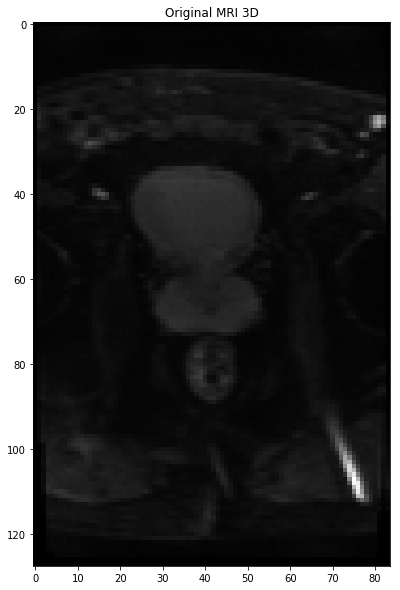

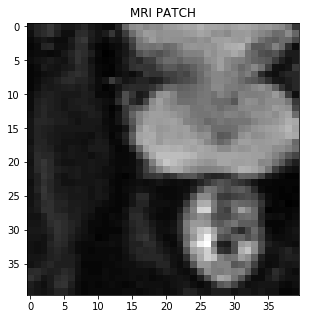

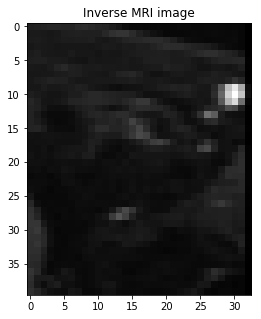

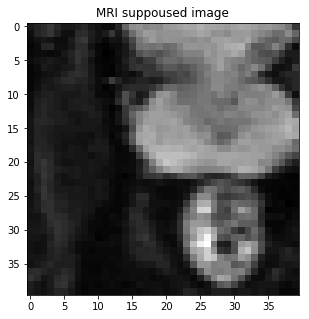

In [33]:
def show_MRI_example(dataset,index):
    row = dataset.iloc[index]
    print ("Este es el paciente {}".format(row.ProxID))
    print ("El diagnostico de este paciente es : {}".format(row.ClinSig))
    print ("El ijk de este paciente es : {}".format(row.ijk))
    print ("La descripción de la imagen dicom es : {}".format(row.Name))
    print ("Este es el finding # {}".format(row.fid))
    print ("El estado de los datos es :{}".format(row.State))
    ijk = row.ijk.split()
    x = int (ijk[0])
    y = int (ijk[1])
    z = int (ijk[2])
    plt.figure(figsize=(10,10))
    plt.imshow(row.MRI3D[z],cmap='gray')
    plt.title("Original MRI 3D")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRIPatch3D[1],cmap='gray')
    plt.title("MRI PATCH")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRI3D[z, x - 20 : x + 20, y-20 : y+20],cmap='gray')
    plt.title("Inverse MRI image")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRI3D[z, y-20 : y+20, x - 20 : x + 20], cmap='gray')
    plt.title("MRI suppoused image")
    
show_MRI_example(training_MRI_imgs_dataframe,23)
#show_MRI_example(testing_MRI_imgs_dataframe,0)

In [19]:
def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [20]:
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe [training_ktrans_imgs_dataframe.State == False] 
training_ktrans_imgs_dataframe_at_PZ = get_dataframe_given_zone("PZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_AS = get_dataframe_given_zone("AS", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_TZ = get_dataframe_given_zone("TZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_SV = get_dataframe_given_zone("SV", training_ktrans_imgs_dataframe)

In [21]:
def get_data_labels (dataFrame):
    indexes = dataFrame.index
    data = dataFrame.KimgPatch3D
    labels = dataFrame.ClinSig
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [22]:
def apply_Kfold_cross_validation(dataframe, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    data, labels = get_data_labels(dataframe)
    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean(), scores.std()*2

In [23]:
results = []
classifier = tree.DecisionTreeClassifier()
print ("Decision Tree Classifier")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "AS"])

Decision Tree Classifier
[0.73076923 0.46153846 0.84615385 0.8        0.92       0.75
 0.75       0.66666667]
Accuracy: 0.74 (+/- 0.26)
[0.83333333 0.81818182 0.90909091 0.8        1.         0.8
 0.7        0.8       ]
Accuracy: 0.83 (+/- 0.17)
[0.28571429 0.85714286 0.57142857 0.42857143 0.85714286 0.57142857
 0.71428571 0.5       ]
Accuracy: 0.60 (+/- 0.38)


In [24]:
classifier = GaussianNB()
print ("GaussianNB Classifier")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "AS"])

GaussianNB Classifier
[0.65384615 0.65384615 0.65384615 0.72       0.68       0.625
 0.625      0.33333333]
Accuracy: 0.62 (+/- 0.22)
[0.66666667 0.63636364 0.27272727 0.9        0.9        0.7
 0.8        0.9       ]
Accuracy: 0.72 (+/- 0.40)
[0.42857143 0.71428571 0.71428571 0.71428571 0.57142857 0.57142857
 0.42857143 0.5       ]
Accuracy: 0.58 (+/- 0.23)


In [25]:
classifier = svm.SVC(kernel='linear', C=1)
print("SVM Classifier linear")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "AS"])

SVM Classifier linear
[0.73076923 0.73076923 0.69230769 0.72       0.76       0.70833333
 0.70833333 0.75      ]
Accuracy: 0.73 (+/- 0.04)
[0.83333333 0.72727273 0.90909091 0.9        0.9        0.9
 0.7        0.9       ]
Accuracy: 0.85 (+/- 0.16)
[0.28571429 0.85714286 1.         0.71428571 0.57142857 0.85714286
 0.57142857 0.5       ]
Accuracy: 0.67 (+/- 0.43)


In [26]:
classifier = svm.SVC(kernel='poly', C=1)
print("SVM Classifier poly")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "AS"])

SVM Classifier poly
[0.80769231 0.61538462 0.84615385 0.8        0.88       0.79166667
 0.70833333 0.79166667]
Accuracy: 0.78 (+/- 0.15)
[0.66666667 0.63636364 0.81818182 0.9        0.9        0.9
 0.7        0.9       ]
Accuracy: 0.80 (+/- 0.22)
[0.14285714 0.85714286 0.85714286 0.57142857 0.57142857 0.57142857
 0.57142857 0.33333333]
Accuracy: 0.56 (+/- 0.45)


In [27]:
classifier = svm.SVC(kernel='rbf', C=1)
print("SVM Classifier rbf")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "AS"])

SVM Classifier rbf
[0.80769231 0.80769231 0.80769231 0.8        0.8        0.83333333
 0.83333333 0.83333333]
Accuracy: 0.82 (+/- 0.03)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.57142857 0.71428571 0.85714286 0.71428571 0.71428571 0.71428571
 0.57142857 0.5       ]
Accuracy: 0.67 (+/- 0.21)


In [29]:
n_estimators = 20
classifier = RandomForestClassifier(n_estimators=n_estimators)
print("Random Forest 20")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "AS"])

Random Forest 20
[0.80769231 0.73076923 0.76923077 0.76       0.8        0.79166667
 0.70833333 0.83333333]
Accuracy: 0.78 (+/- 0.08)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.8        0.9       ]
Accuracy: 0.88 (+/- 0.08)
[0.57142857 1.         0.28571429 0.71428571 0.85714286 0.57142857
 0.57142857 0.66666667]
Accuracy: 0.65 (+/- 0.40)


In [30]:
n_neighbors=20
classifier = neighbors.KNeighborsClassifier(n_neighbors)
print("K Nearest Neighbors 20")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "AS"])

K Nearest Neighbors 20
[0.80769231 0.80769231 0.80769231 0.84       0.8        0.83333333
 0.83333333 0.83333333]
Accuracy: 0.82 (+/- 0.03)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.42857143 0.85714286 1.         0.85714286 0.57142857 0.85714286
 0.42857143 0.5       ]
Accuracy: 0.69 (+/- 0.43)


In [31]:

def create_training_file(dataframe, FileName):
    FileName = FileName +".txt"
    data, labels = get_data_labels (dataframe)
    number_of_samples, number_of_features = data.shape
    print(number_of_samples, number_of_features)
    with open(FileName, "w") as text_file:
        str_line = ""
        for i in range (number_of_samples):
            print ("This is the line {}".format(i))
            str_line = "{} ".format(str(int(labels[i])))
            for j in range (number_of_features):
                str_line = "{} {}:{}".format(str_line, (j+1) , data[i,j])
            print(str_line)
            print ("=================================================================================================")
            text_file.write(str_line)
            if (i != len(data)):
                text_file.write("\n")
            str_line = ""
        text_file.close()

In [32]:

dataframe = training_ktrans_imgs_dataframe_at_PZ
FileName= "training_ktrans_imgs_dataframe_at_PZ"
create_training_file(dataframe,FileName)

dataframe = training_ktrans_imgs_dataframe_at_AS
FileName= "training_ktrans_imgs_dataframe_at_AS"
create_training_file(dataframe,FileName)

dataframe = training_ktrans_imgs_dataframe_at_TZ
FileName= "training_ktrans_imgs_dataframe_at_TZ"
create_training_file(dataframe,FileName)

200 4800
This is the line 0
1  1:0.0 2:0.0245274386109848 3:0.0 4:0.0 5:0.028254279077296784 6:0.009972286609777574 7:0.0 8:0.0 9:0.0 10:0.0 11:0.0 12:0.0 13:0.08609774555605545 14:0.8058504744444669 15:0.8359157502122756 16:0.8534413555018611 17:0.0 18:0.0 19:0.0 20:0.0 21:0.10446148848278156 22:0.17592374344477704 23:0.05204592037451377 24:0.0 25:0.0 26:0.0 27:0.0 28:0.0264094552081537 29:0.0 30:0.013134427202520636 31:0.01213233159101336 32:0.0 33:0.022564613308750116 34:0.11096252427233637 35:0.1625342766890056 36:0.08477708993025455 37:0.3042406053048999 38:0.4345116646798109 39:0.24221722988771957 40:0.8101116731929824 41:0.07458422605077457 42:0.08390794611749937 43:0.08050282472124475 44:0.05078222540035813 45:0.039524297234061874 46:0.0 47:0.020081650824204354 48:0.060381115097438605 49:0.0 50:0.0 51:0.0 52:0.0 53:0.014190232405656205 54:0.5183110228788568 55:0.6015080367574743 56:0.0 57:0.0 58:0.0 59:0.0 60:0.11632537482783499 61:0.31599918855653375 62:0.10757025639938675 63:

1  1:0.0 2:0.0 3:0.0 4:0.0 5:0.0 6:0.07283597447170194 7:0.40945063450322516 8:0.4436242273704884 9:0.03883375130694816 10:0.11766829468476134 11:0.060224490691750274 12:0.00048271740577078906 13:0.03579627007898412 14:0.021341957747739917 15:0.027792424310925906 16:0.018705565194394636 17:0.20959018527493625 18:0.19769693820017062 19:0.009174170399326123 20:0.004526886503694321 21:0.2562373063844128 22:0.0 23:0.0 24:0.0 25:0.9708091790807291 26:1.7895163936680671 27:0.0 28:0.0 29:0.0 30:0.0 31:0.0 32:0.0 33:0.00533144706283218 34:0.022022204280788257 35:0.0032627405918449785 36:0.006934904154973481 37:0.005581814520162601 38:0.0 39:0.0 40:0.09676660415150201 41:0.0 42:0.0 43:0.0 44:0.0 45:0.006809912632039623 46:0.47822164564939107 47:1.0372955637122832 48:0.7346657561099079 49:0.02470546552290593 50:0.11351505408490625 51:0.0596512222402676 52:0.005254386073791432 53:0.017999957077535 54:0.0 55:0.02406124077281578 56:0.18881086331970184 57:0.27199134554705745 58:0.2579985213781137 59

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




This is the line 18
1  1:0.7510327746384242 2:0.6097985252716098 3:0.6104308834329973 4:1.6035851803757961 5:1.8214191791820553 6:1.1363009921259712 7:0.7794459861989224 8:0.03621580573620095 9:0.0 10:0.0 11:0.0 12:0.0 13:0.0 14:0.0 15:0.0 16:0.0 17:0.0 18:0.0 19:0.0 20:0.0 21:0.0 22:0.0 23:0.01747375433344775 24:0.02689141969805028 25:0.2398932540584908 26:0.21111904804038556 27:0.025152817763204455 28:0.0 29:0.19386649726493757 30:0.042944988716914795 31:0.004918765684314619 32:0.0 33:0.0 34:0.0 35:0.0 36:0.0 37:0.0 38:0.0 39:0.0 40:0.0 41:0.054433260658006064 42:0.027472033128965 43:0.6309988780045399 44:0.894883467815995 45:1.0824635544339687 46:0.5935808083758709 47:0.5917274207709928 48:0.058684976557384735 49:0.0 50:0.0 51:0.0 52:0.0 53:0.0 54:0.0 55:0.0 56:0.0 57:0.0 58:0.0 59:0.0 60:0.0 61:0.0 62:0.0 63:0.0 64:0.011831232088793508 65:0.05193268310265348 66:0.1948044155044063 67:0.0065795288331301615 68:0.0 69:0.02564456323027061 70:0.06368859157228066 71:0.0 72:0.0 73:0.0 74:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
kfolds = 8
dataframe = training_ktrans_imgs_dataframe_at_PZ
c_PZ = 32
gamma_PZ = 0.0001220703125
kernel_PZ = "rbf"
classifier_PZ = svm.SVC(kernel=kernel_PZ, gamma = gamma_PZ, C = c_PZ)
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier_PZ, kfolds)
results.append(["SVM Optimized",experiments, mean, std , "PZ"])

dataframe = training_ktrans_imgs_dataframe_at_TZ
c_TZ = 0.03125 
gamma_TZ =0.0078125 
kernel_TZ = "rbf"
classifier_TZ = svm.SVC(kernel=kernel_TZ, gamma = gamma_TZ, C = c_TZ)
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier_TZ, kfolds)
results.append(["SVM Optimized",experiments, mean, std , "TZ"])

dataframe = training_ktrans_imgs_dataframe_at_AS
c_AS =2.0
gamma_AS =0.001953125
kernel_AS = "rbf"
classifier_AS = svm.SVC(kernel=kernel_AS, gamma = gamma_AS, C = c_AS)
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier_AS, kfolds)
results.append(["SVM Optimized",experiments, mean, std , "AS"])

[0.73076923 0.76923077 0.80769231 0.72       0.68       0.875
 0.83333333 0.75      ]
Accuracy: 0.77 (+/- 0.12)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.57142857 0.71428571 0.71428571 0.71428571 0.57142857 0.71428571
 0.71428571 0.33333333]
Accuracy: 0.63 (+/- 0.26)


In [34]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean", "Scores's std",'Zone'])
display(results_dataframe)

Classifier                                             Scores  \
0            Decision Tree  [0.7307692307692307, 0.46153846153846156, 0.84...   
1            Decision Tree  [0.8333333333333334, 0.8181818181818182, 0.909...   
2            Decision Tree  [0.2857142857142857, 0.8571428571428571, 0.571...   
3               GaussianNB  [0.6538461538461539, 0.6538461538461539, 0.653...   
4               GaussianNB  [0.6666666666666666, 0.6363636363636364, 0.272...   
5               GaussianNB  [0.42857142857142855, 0.7142857142857143, 0.71...   
6               SVM Linear  [0.7307692307692307, 0.7307692307692307, 0.692...   
7               SVM Linear  [0.8333333333333334, 0.7272727272727273, 0.909...   
8               SVM Linear  [0.2857142857142857, 0.8571428571428571, 1.0, ...   
9                 SVM poly  [0.8076923076923077, 0.6153846153846154, 0.846...   
10                SVM poly  [0.6666666666666666, 0.6363636363636364, 0.818...   
11                SVM poly  [0.14285714285714285, 0.8571428571428571, 0.85...   
12                 SVM rbf  [0.8076923076923077, 0.8076923076923077, 0.807...   
13                 SVM rbf  [0.8333333333333334, 0.9090909090909091, 0.909...   
14                 SVM rbf  [0.5714285714285714, 0.7142857142857143, 0.857...   
15        Random Forest 20  [0.8076923076923077, 0.7307692307692307, 0.769...   
16        Random Forest 20  [0.8333333333333334, 0.9090909090909091, 0.909...   
17        Random Forest 20  [0.5714285714285714, 1.0, 0.2857142857142857, ...   
18  K Nearest Neighbors 20  [0.8076923076923077, 0.8076923076923077, 0.807...   
19  K Nearest Neighbors 20  [0.8333333333333334, 0.9090909090909091, 0.909...   
20  K Nearest Neighbors 20  [0.42857142857142855, 0.8571428571428571, 1.0,...   
21           SVM Optimized  [0.7307692307692307, 0.7692307692307693, 0.807...   
22           SVM Optimized  [0.8333333333333334, 0.9090909090909091, 0.909...   
23           SVM Optimized  [0.5714285714285714, 0.7142857142857143, 0.714...   

    Scores's mean  Scores's std Zone  
0        0.740641      0.255411   PZ  
1        0.832576      0.165610   TZ  
2        0.598214      0.377542   AS  
3        0.618109      0.222751   PZ  
4        0.721970      0.396145   TZ  
5        0.580357      0.230765   AS  
6        0.725064      0.042225   PZ  
7        0.846212      0.160026   TZ  
8        0.669643      0.434116   AS  
9        0.780112      0.154999   PZ  
10       0.802652      0.217749   TZ  
11       0.559524      0.448606   AS  
12       0.815385      0.028437   PZ  
13       0.893939      0.046454   TZ  
14       0.669643      0.213540   AS  
15       0.775128      0.077567   PZ  
16       0.881439      0.076986   TZ  
17       0.654762      0.400538   AS  
18       0.820385      0.029888   PZ  
19       0.893939      0.046454   TZ  
20       0.687500      0.428199   AS  
21       0.770753      0.120399   PZ  
22       0.893939      0.046454   TZ  
23       0.630952      0.255329   AS